In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from __future__ import print_function
import numpy as np
#from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 14, 'lines.markersize' : 4})
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import sys, os
import time, datetime
from datetime import timedelta
import pandas as pd
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
from cart2pol import PolarRebin
import scipy.ndimage as scimg
#sys.path.append('/cds/home/p/paris/reconVMI_clean/recon X510 Jan')
#from torchrecon_funcs_cal import *

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0:2,-1] = 0
my_cmap = ListedColormap(my_cmap)

In [6]:
def rebin(arr, n=2):
    sy, sx = arr.shape
    shape = (int(sy/n), int(n), int(sx/n), int(n))
    return np.nanmean(np.nanmean(arr.reshape(shape), axis=-1), axis=1)

def pix_2_eV(pixel, pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512):
    '''
    pixel: array of pixel indices
    pixpereV: calibration pixels per eV
    spectral_hw: (optional) central energy if you have absolutes
    spectra_pix0: where to put w = 0, 512 is at the center for 1024pix spectrometer 
    '''
    spectra_dhwdpix = 1./pixpereV
    spectra_hws_eV = spectra_hw0 + spectra_dhwdpix*(pixel -spectra_pix0)
    return spectra_hws_eV


In [7]:
def gaus(x, a, mu, sig):
    return a*1/sig/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sig)**2)


def gaus_fit(t,spec):
    #spec = Et*Et.conj()
    popt, pcov = curve_fit(gaus,t,spec, bounds=([0.1, -50, 0.01], [100, 50, 30]))
    a, mu, sig = popt
    return a, mu, sig #FWHM is 2.355*sig

In [8]:
def FWHM(t, spec): 
    peakMax = np.max(spec)
    indMax = np.where(spec == peakMax)[0] #should be center since rolled
    if len(indMax)>1: indMax = np.max(indMax)
    t1 = 0
    t2 = 0
    
    for i in range(int(len(t)/2)):
        if t2 != 0 and t1 != 0:
            break
        if i < indMax: 
            if spec[i] >= 0.5*peakMax and t1 == 0:
                t1 = t[i]
            if spec[-i] >= 0.5*peakMax and t2 == 0:
                t2 = t[-i]  
    return t2-t1

def FWHM2(t, spec): 
    spec = spec/np.sum(spec)
    peakMax = np.max(spec)
    indMax = np.where(spec == peakMax)[0] 
    if len(indMax)>1: indMax = np.max(indMax)
    else: indMax = indMax[0]
    t1 = 0
    t2 = 0
    ind1 = 0
    ind2 = 0
    
    for i in range(int(len(t))):
        if t2 != 0 and t1 != 0:
            break
        if i < indMax:
            #print(i, np.trapz(spec[-i:]))
            
            if (np.trapz(spec[:i]) >= 0.25) & (t1 == 0):
                t1 = t[i]
                ind1 = i
            elif (np.trapz(spec[-(i+1):]) >= 0.25) & (t2 == 0):
                t2 = t[-(i+1)]  
                ind2 = -(i+1)
    return t2-t1 #, ind1, ind2

In [9]:
def peak_power(EtEt, ts,  gmd):
    EtEt = EtEt/np.sum(EtEt)
    dt_flat = np.trapz(EtEt,1e15*ts)/np.max(EtEt)
    #print(dt_flat)
    PP = gmd/dt_flat
    return PP

    

In [10]:
def gaus(xx, sig,x0):
    g = 1/sig/np.pi/2*np.exp(-1/2*((xx-x0)/sig)**2)
    m = np.max((np.max(g), 0.00001))
    g = g/m 
    return g

def doubleg_gaus(xx, sig1, sig2, x01, x02, a):
    g1 = gaus(xx, sig1, x01)
    g2 = a*gaus(xx, sig2, x02)
    return g1 + g2

from scipy.optimize import minimize
from scipy.interpolate import interp1d

def err_func(x0, xx, x, y):
    sig1, sig2, x01, x02, a = x0[0],x0[1],x0[2],x0[3],x0[4]
    gg = doubleg_gaus(xx, sig1, sig2, x01, x02, a)
    f = interp1d(xx,gg)
    gg = f(x)
    SSE = np.sum((gg-y)**2)
    return SSE

def com(x,y):
    f = interp1d(x,y)
    x = np.linspace(x[0],x[-1], 100)
    y = f(x)
    y[y<0.05*np.max(y)] = 0
    cm = np.trapz(x*y)/np.sum(y)
    return(cm)
    

In [11]:
#basesdir = '/reg/d/psdm/tmo/tmox51020/results/paris/circularpol_vNbases_dipole_K5/'
basesdir = '/reg/d/psdm/tmo/tmox51020/results/paris/circularpol_vNbases_dipole_Feb/'
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5') 


In [58]:
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar10_110.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar12_112.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar14_121.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar16_122.npy'
# # fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar17_123.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar20_123.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar19_124.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar25_127.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar23_125.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_May31_127.npy'
# fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Mar28_112.npy'

fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Aug3_127.npy'
#fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_Aug8_112.npy'
run =  int(fname.split('torch_')[1].split('_')[1].split('.npy')[0])
print(run)
dats = np.load(fname, allow_pickle = True)[()]

127


In [59]:
dat = dats['dat']
mask = dats['mask']
mdatname = dats['mdatname']
specdatname = dats['specdatname']
gfsig = dats['gfsig']
eshift = dats['eshift']
sc = dats['sc']
gfcart = 0.25
thresh = dats['thresh'] #0.0005
print(mdatname)

/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug3_127.npy


In [60]:
mdat= np.load(mdatname , allow_pickle = True)[()]
specdat = np.load(specdatname, allow_pickle = True)[()]
gds = np.load(mdatname.split('Ms')[-0]+'GDs'+mdatname.split('Ms')[-1],allow_pickle=True)[()]
tmstmps = np.load(mdatname.split('Ms')[-0]+'tmpstmps'+mdatname.split('Ms')[-1],allow_pickle=True)[()]

In [61]:
Ups = np.unique(dat['Up'])
print(Ups)

[0.   0.05 0.1  0.2  0.3  0.4  0.5  1.  ]


In [62]:
try: Bps
except:
    Bps = []
    alphas = []
    vNaxiss = []
    alphaws = []
    Bnames = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    if Up == 0: Up = int(0)
    filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
    print(filename)
    if filename in Bnames: continue
    br = np.load(basesdir+filename, allow_pickle=True)
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    breal = br[()]['breal']
    bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    tempr = np.zeros((Breal.shape[0], 64**2))
    tempi = np.zeros((Breal.shape[0], 64**2))
    for i in range(len(Breal)):
        tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
        tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

    Breal = tempr
    Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        f = interp1d(vNaxis['t_sample'], alpha['t_sample'][i], fill_value = 0, bounds_error = False)
        N = 2801 #1024
        ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
        alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag
    Bnames.append(filename)
    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Np128_Nw6_Nt6_Up0.npy
Bpbasis_Np128_Nw6_Nt6_Up0.05.npy
Bpbasis_Np128_Nw6_Nt6_Up0.1.npy
Bpbasis_Np128_Nw6_Nt6_Up0.2.npy
Bpbasis_Np128_Nw6_Nt6_Up0.3.npy
Bpbasis_Np128_Nw6_Nt6_Up0.4.npy
Bpbasis_Np128_Nw6_Nt6_Up0.5.npy
Bpbasis_Np128_Nw6_Nt6_Up1.0.npy


Text(0.5, 1.0, 'False')

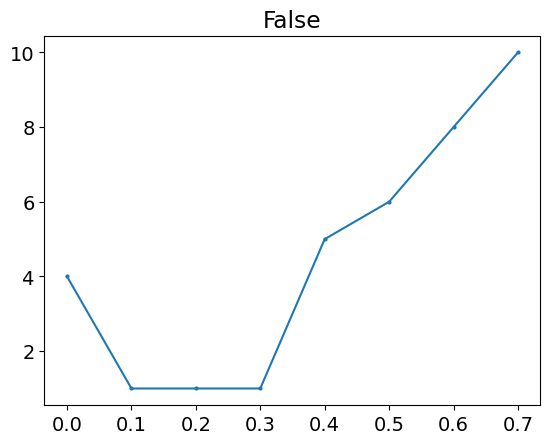

In [63]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
y = np.array([ 4, 1, 1, 1, 5, 6, 8, 10])
plt.plot(x,y, '.-')
convergesUp = False
idx1 = np.argmin(y)
y2 = np.copy(y)
y2[idx1] = 2*np.max(y)
idx2 = np.argmin(y2)
if (np.abs(idx1-idx2) == 1) and (idx1 != 0): convergesUP = True
Upb = idx1
#when finding if Up converges and Upb
#allow for each Up the worst (least likely) seed to be dropped
plt.title(convergesUp)

In [78]:
l = 13
# datall = np.ndarray(len(dat), dtype = [('run', int),('seed', int),('ID', int),('Up', float), ('Qs', float, 2*36-1),\
#                                       ('costs', float,l), ('costM', float,l), 
#                                       ('std_t', float), ('fwhm2', float), ('fwhm', float),\
#                                       ('gmd', float), ('Upb', bool), ('peak_power', float), ('Qb', bool),\
#                                       ('spec',float,1024),\
#                                         ])


datall = np.ndarray(len(dat), dtype = [('run', int),('seed', int),('ID', int),('Up', float), ('Qs', float, 2*36-1),\
                                      ('costs', float,l), ('costM', float,l), 
                                      ('std_t', float), ('fwhm2', float), ('fwhm', float),\
                                      ('gmd', float), ('Upb', bool), ('peak_power', float), ('Qb', bool),\
                                      ('spec',float,1024),('EtEt', float, 2801), ('timestamp', int),\
                                      ('Qw', bool), ('Up_conv', bool),\
                                        ])

## run: run id
## seed: random see id
## ID: shot id
## Up: Up of the reconstruction
## Upb: "best" Up, Up min
## Qb: "best" Q, Q of the most likely time reconstruction
## Qw: "worst" Up, least likely reconstrctions
## Up_conv: if the Up curve converges, looking for 2 mins next to each other and min not at the lowest Up

In [83]:
eshift = np.unique(dat['eshift'])
IDs = np.unique(dat['ID'])
thresh = dats['thresh']

numseed = len(np.unique(dat['seed']))
Ups = np.unique(dat['Up'])


for i in range(len(dat)):
    look = dat[i]
    u = int(np.where(Ups == look['Up'])[0])
    
    Ups_i = np.unique(dat[(dat['ID'] == IDs[k])]['Up'])
    for u in range(len(Ups_i)):
        uplook = Ups_i[u]
        seeds = np.unique(dat[(dat['ID'] == IDs[k])&(dat['Up'] == uplook)]['seed'])
        ets = []

        Bp = Bps[up_order[u]]
        vNaxis = vNaxiss[up_order[u]]
        alpha = alphas[up_order[u]]
        alphw = alphaws[up_order[u]]
        ts = vNaxis['t_sample']
        t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
        t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)

        m = mdat[IDs[k]]
        #spec = specdat[IDs[k]]
        #spec = np.roll(spec,30)
        m = m/np.sum(m)
        # N = 2801
        # xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2
        # eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
        # #Interpolate spec outside of the loop to match eV
        # xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
        # xeV = xeV - eshift#3 #know this from previous calibration

        for s in range(len(seeds)):
            dat0 = dat[(dat['ID'] == IDs[k])&(dat['Up'] == uplook)&(dat['seed']== seeds[s])]
            Q = np.squeeze(dat0['Qs'])

            #datall[k*numUp*numseed+u*numseed+s]['seed'] = seeds[s]
            datall[ii]['seed'] = seeds[s]
            datall[ii]['Qs'] = Q
            datall[ii]['costs'] = dat0['costs']
            datall[ii]['costM'] = dat0['costM']
            datall[ii]['ID'] = IDs[k]
            datall[ii]['run'] = run
            datall[ii]['Up'] = uplook
            datall[ii]['gmd'] = gds[IDs[k]]
            datall[ii]['spec'] = specdat[IDs[k]]
            datall[ii]['timestamp'] = tmstmps[IDs[k]]


            N_basis = 36
            eVshift_idx = 0
            Q1=Q[0:N_basis]
            Q1=np.reshape(Q1,[1,N_basis])
            Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
            Q2=np.reshape(Q2,[1,N_basis])
            Qguess=Q1+1j*Q2
            Qguess=np.reshape(Qguess,[N_basis,1])
            Mgr=np.real(np.matmul(np.matmul(Qguess,Qguess.conj().transpose()).transpose().flatten(),Bp))
            Mgr=Mgr/np.sum(Mgr)
            Mgr[Mgr<thresh] = 0
            Mgr=Mgr/np.sum(Mgr)

            alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
            #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
            Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

            f = interp1d(vNaxis['t_sample'],Et, fill_value = 0, bounds_error = False)
            Et_l = f(np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], len(vNaxis['t_sample'])))
            aghh = np.argmax(np.abs(Et_l))
            Ew = np.fft.ifftshift(np.fft.ifft(np.roll(Et_l,-aghh))) #need this to get imag part, must be evenly spaced
            #Ew = np.squeeze(np.matmul(Qguess.T,alphw))
            EwEw = np.real(Ew*Ew.conj())
            EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
            EwEw = EwEw/np.max(EwEw)
            wphase = np.unwrap(np.angle(Ew))
            wphase = wphase - np.mean(wphase)
            Ew = np.squeeze(np.matmul(Qguess.T,alphw)) 
            EwEw = np.real(Ew*Ew.conj())
            EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
            EwEw = EwEw/np.max(EwEw)


            pscale = 1/np.max(m/np.sum(m*mask))
            Mt = m/np.sum(m*mask)*pscale
            Mp = pscale*np.reshape(Mgr/np.sum(mask*np.reshape(Mgr, [64,64])), [64,64])
                #Mp = Mp/np.max(Mp)
                #tosave[str(k) + '_Q'] = Q
                #tosave[str(k) + '_Up'] = uplook

           

            EtEt = np.abs(Et*Et.conj())
            EtEt = EtEt/np.max(EtEt)

            roll_to = np.argmax(EtEt[t1:t2])
            datall[ii]['EtEt'] = EtEt
            datall[ii]['fwhm']= FWHM(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))
            datall[ii]['fwhm2']=FWHM2(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))
            # a,mu,sig = gaus_fit(ts*1e15,np.roll(EtEt, int(len(EtEt)/2)-roll_to))
            # duration.append(2.355*sig)

            #datall[k*numseed+s]['fwhm'](FWHM(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to)))

        
        
        
        
        
            ets.append(EtEt)
            ii+=1
    
        std_t=(np.sum(np.std(np.array(ets),axis = 0)))
        pp = peak_power(np.mean(ets,axis= 0),ts,gds[k])
         if u == 0: datall[ii]['Upb'] = True
            else: datall[ii]['Upb'] = False

        likely = []
        for n in range(len(ets)):
            datall[ii-len(ets)+n]['std_t'] = std_t
            datall[ii-len(ets)+n]['peak_power'] = pp
            dot = []
            for l in range(len(ets)):
                if n != l:
                    dot.append(np.dot(ets[n]/np.linalg.norm(ets[n]),ets[l]/np.linalg.norm(ets[l])))
            likely.append(np.sum(dot))
        
        for n in range(len(likely)):
            if n == np.argmax(likely):
                datall[ii-len(likely)+n]['Qb'] = True
            else: datall[ii-len(likely)+n]['Qb'] = False
            
            

IndentationError: unexpected indent (2627741118.py, line 120)

In [ ]:
plt.hist(datall['gmd'])
plt.show()
plt.hist(datall['peak_power'])
plt.show()
plt.hist(datall['gmd']/datall['fwhm2'])
plt.show()

In [ ]:
datdict = {}
datdict['datall'] = datall
datdict['mask'] = mask
datdict['mdatname'] = mdatname
datdict['specdatname'] = specdatname
datdict['gfsig'] = gfsig 
datdict['eshift'] = eshift
datdict['sc'] = sc
datdict['sc'] = thresh

In [ ]:
#savename = fname.split('recon/')[1].split('.npy')[0]+'_summary.npy'
savename = fname.split('recon/')[1].split('.npy')[0]+'_datdict.npy'
savename

In [82]:
np.save(savename, datdict)

In [77]:
datall.dtype.names

('run',
 'seed',
 'ID',
 'Up',
 'Qs',
 'costs',
 'costM',
 'std_t',
 'fwhm2',
 'fwhm',
 'gmd',
 'Upb',
 'peak_power',
 'Qb',
 'spec',
 'Qw',
 'Up_conv')

In [73]:
len(runl)

68

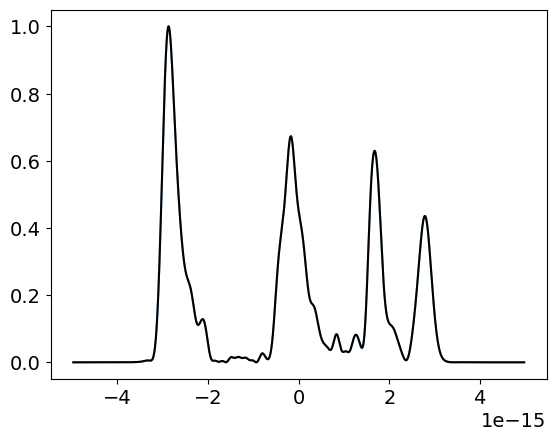

In [24]:
for i in range(len(ets)):
    plt.plot(vNaxis['t_sample'],ets[i], alpha = 0.5)

plt.plot(vNaxis['t_sample'],ets[np.argmax(likely)], 'k')

In [296]:
np.argmax(likely)

1

In [299]:
datall[ii-len(likely)+1]['Qb']

True

16.53887785077578

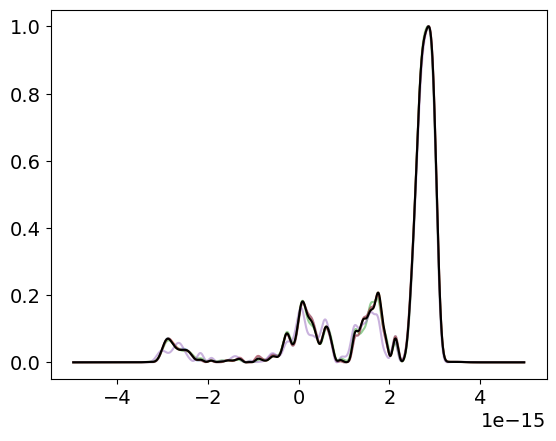

In [300]:
likely = []
for i in range(len(ets)):
    plt.plot(vNaxis['t_sample'],ets[i], alpha = 0.5)
    dot = []
    for j in range(len(ets)):
        if i != j:
            dot.append(np.dot(ets[i]/np.linalg.norm(ets[i]),ets[j]/np.linalg.norm(ets[j])))
    likely.append(np.sum(dot))
    

plt.plot(vNaxis['t_sample'],ets[np.argmax(likely)], 'k')
#plt.xlim(-4e-15,-1e-15)
(np.sum(np.std(np.array(ets),axis = 0)))

In [301]:
np.argmax(likely)

1

In [283]:
datall[ii-len(likely):ii-len(likely)+6]['Qb']

array([False, False,  True, False])

In [175]:
datall[3513]['Qb']

False

In [17]:
d1 = np.load('torch_Mar10_110_summary.npy', allow_pickle = True)[()]
d2 = np.load('torch_Mar12_112_summary.npy', allow_pickle = True)[()]
d3 = np.load('torch_Mar14_121_summary.npy', allow_pickle = True)[()]
d4 = np.load('torch_Mar16_122_summary.npy', allow_pickle = True)[()]
#d5 = np.load('torch_Mar17_123_summary.npy', allow_pickle = True)[()]
d5 = np.load('torch_Mar20_123_summary.npy', allow_pickle = True)[()]
d6 = np.load('torch_Mar19_124_summary.npy', allow_pickle = True)[()]
d7 = np.load('torch_Mar23_125_summary.npy', allow_pickle = True)[()]
#d8 = np.load('torch_Mar25_127_summary.npy', allow_pickle = True)[()]
d8 = np.load('torch_May31_127_summary.npy', allow_pickle = True)[()]
d9 = np.load('torch_Mar28_112_summary.npy', allow_pickle = True)[()]

In [18]:
datall = np.concatenate([d1,d2,d3,d4,d5,d6,d7,d8,d9])
len(datall)
# datall = np.concatenate([d1,d2,d3,d4,d5,d6,d7,d9])
# datall = np.concatenate([d1,d2,d9])
# datall = np.concatenate([d3,d4,d5,d6,d7,d8])
#datall = np.load('torch_Mar28_112_summary_wspec.npy', allow_pickle= True)[()]

26933

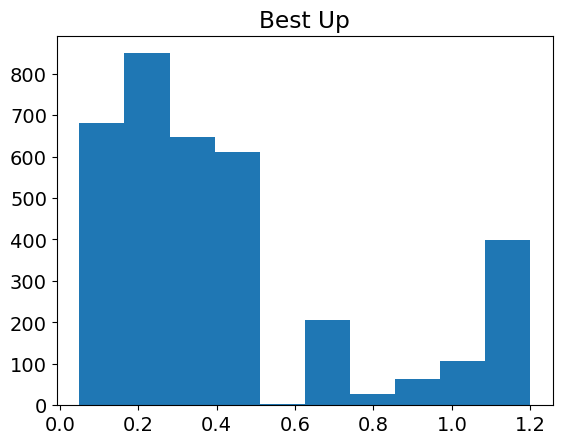

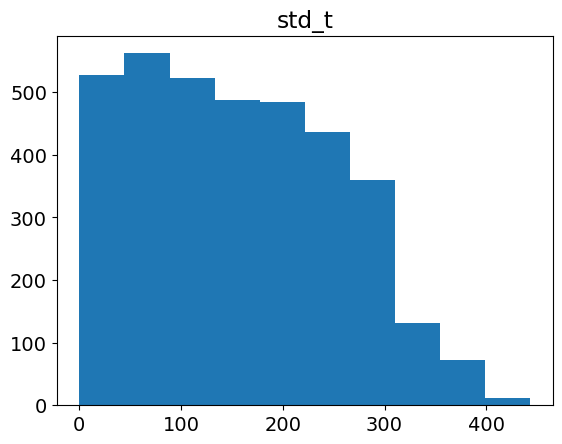

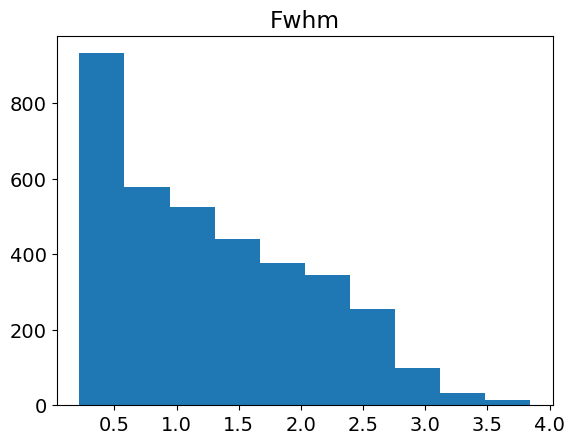

In [19]:
plt.hist(datall[(datall['Upb'] == True)]['Up'])
plt.title('Best Up')
plt.show()
plt.hist(datall[(datall['Upb'] == True)]['std_t'])
plt.title('std_t')
plt.show()
plt.hist(datall[(datall['Upb'] == True)]['fwhm2'])
plt.title('Fwhm')
plt.show()

68


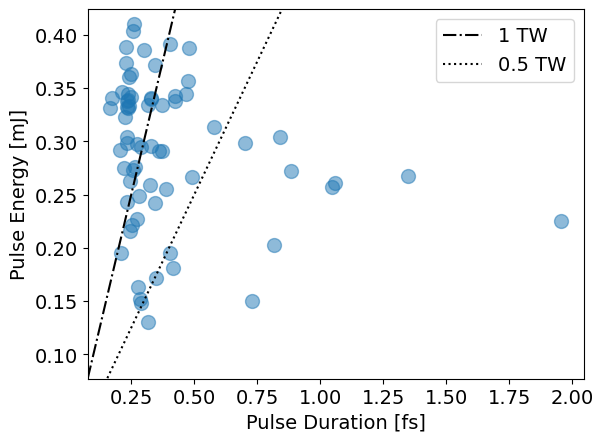

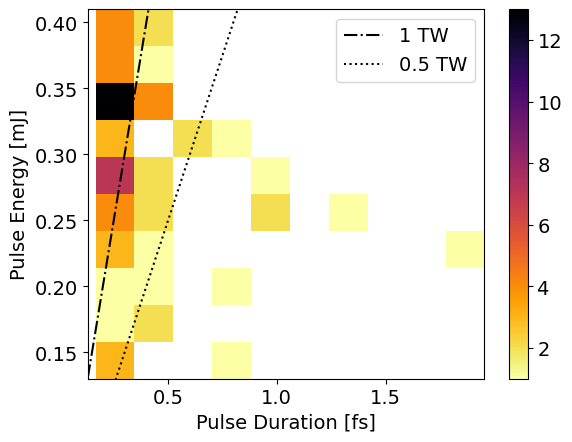

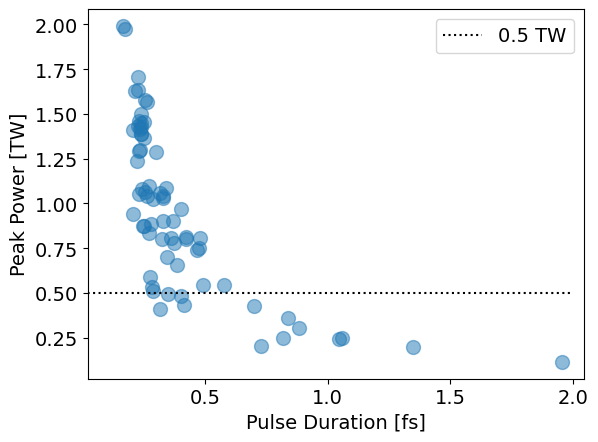

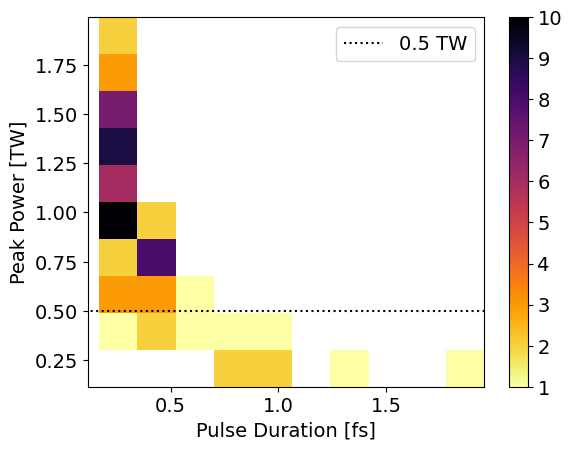

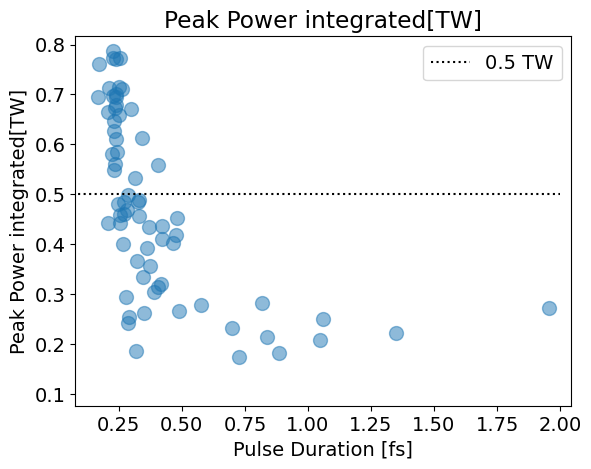

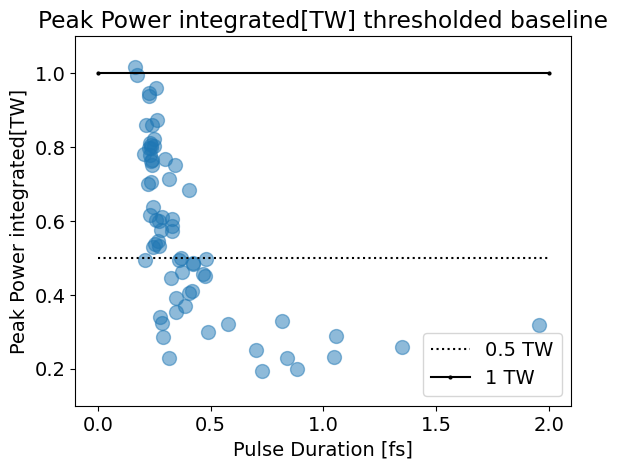

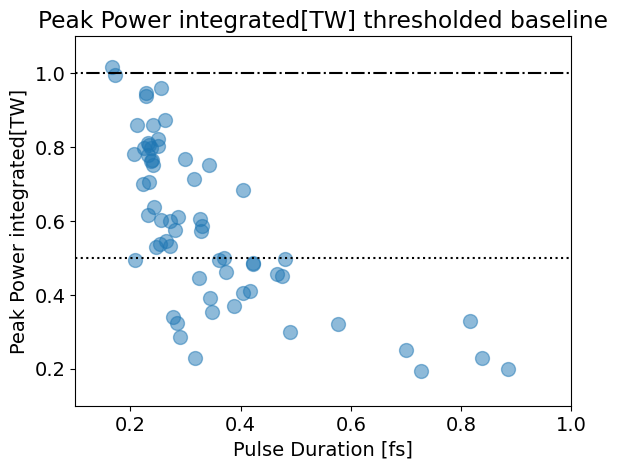

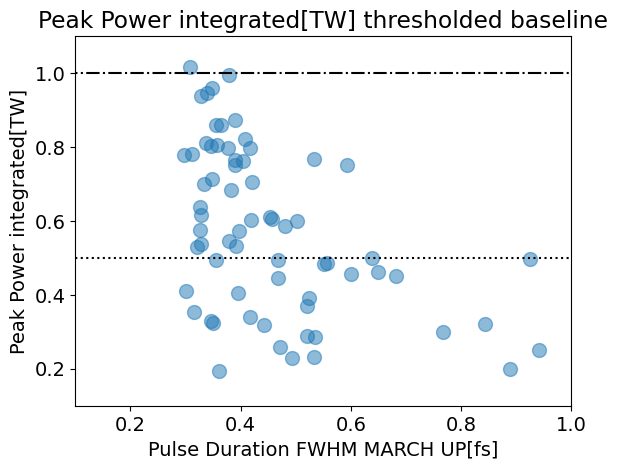

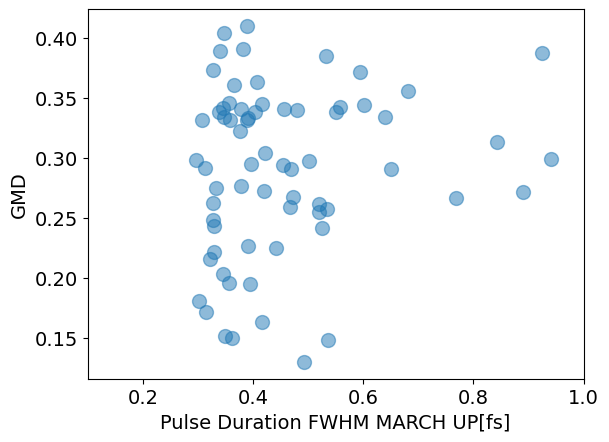

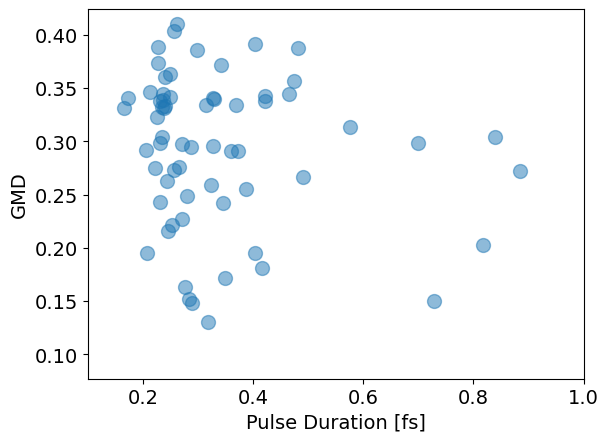

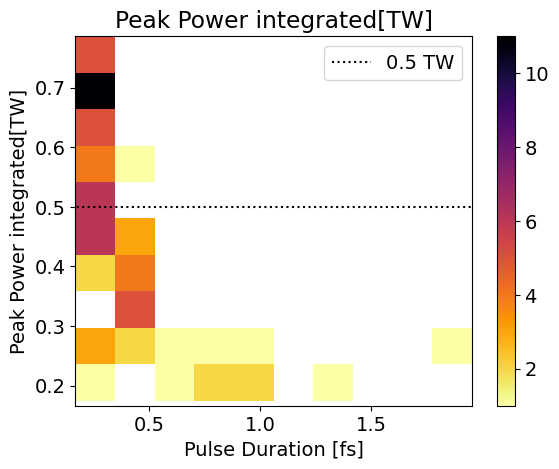

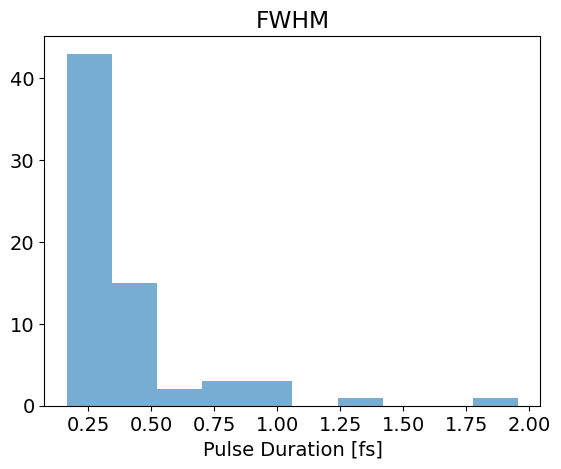

In [20]:
#cut = (datall['Upb'] == True) & (datall['Up'] >= 0.3) & (datall['std_t']<60)
cut = (datall['Upb'] == True) & (datall['Up'] >= 0.3) & (datall['std_t']<50)
pixpereV = 22
xeV = pix_2_eV(np.arange(1024), pixpereV = pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
gmds = []
std_ts = []
std_ws = []
specs = []
bandwidths = []
ids = []
fwhms = []
fwhms2 = []
upss = []
pps = []
pps_trunc = []
ets = []
runl =[]
t1 = 0
t2 = -1
ts = vNaxis['t_sample']
for r,rname in enumerate(np.unique(datall[cut]['run'])):
    
    for i, idx in enumerate(np.unique(datall[cut]['ID'])):
        test = datall[cut & (datall['ID'] == idx)& (datall['run'] == rname)]
        if len(test)>0:
            if (np.min(datall[datall['run'] == rname]['Up']) < np.min(test['Up'])): #if the min Up for the run is less than the best Up
                if len(test[test['Qb']])>0:

                    Q = np.squeeze(test[test['Qb']]['Qs']) #Qb is the most likely trace
                    N_basis = 36
                    eVshift_idx = 0
                    Q1=Q[0:N_basis]
                    Q1=np.reshape(Q1,[1,N_basis])
                    Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
                    Q2=np.reshape(Q2,[1,N_basis])
                    Qguess=Q1+1j*Q2
                    Qguess=np.reshape(Qguess,[N_basis,1])
                    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
                    #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
                    Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

                    EtEt = np.abs(Et*Et.conj())
                    EtEt = EtEt/np.max(EtEt)
                    ets.append(np.copy(EtEt))
                    
                    roll_to = np.argmax(EtEt[t1:t2])

                    ids.append(int(np.mean(test['ID'])))
                    std_ts.append(np.mean(test['std_t']))
                    gmds.append(np.mean(test['gmd']))
                    specs.append(np.mean(test['spec'],axis = 0))
                    fwhms.append(np.mean(test['fwhm']))
                    #fwhms2.append(np.mean(test['fwhm2']))
                    upss.append(test['Up'][0]) #np.mean(test['Up']))
                    runl.append(rname)
                    bandwidths.append(FWHM(xeV,np.mean(test['spec'],axis = 0)))

                    pps.append(peak_power(EtEt,ts, test[0]['gmd']))
                    EtEt[EtEt<0.1*np.max(EtEt)] = 0
                    pps_trunc.append(peak_power(EtEt,ts,test[0]['gmd']))
                    fwhms2.append(FWHM2(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))) #50% the power
                    
                    ewews = []
                    for jj in range(len(test)):
                        Q = np.squeeze(test[test['Qb']]['Qs']) #Qb is the most likely trace
                        N_basis = 36
                        eVshift_idx = 0
                        Q1=Q[0:N_basis]
                        Q1=np.reshape(Q1,[1,N_basis])
                        Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
                        Q2=np.reshape(Q2,[1,N_basis])
                        Qguess=Q1+1j*Q2
                        Qguess=np.reshape(Qguess,[N_basis,1])

                        Ew = np.squeeze(np.matmul(Qguess.T,alphw)) 
                        EwEw = np.real(Ew*Ew.conj())
                        EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
                        EwEw = EwEw/np.max(EwEw)
                        ewews.append(EwEw)
                    std_ws.append(np.sum(np.std(np.array(ewews),axis = 0)))
                    
    
print(len(fwhms2))

plt.plot(fwhms2, gmds, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Pulse Energy [mJ]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0,2], 'k-.',label = '1 TW')
plt.plot([0,2],[0,1], 'k:',label = '0.5 TW')
plt.legend()
plt.show()
    
plt.hist2d(fwhms2, gmds, cmap = 'inferno_r', cmin = 1) #, bins = 30)
plt.colorbar()
plt.ylabel('Pulse Energy [mJ]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0,2], 'k-.',label = '1 TW')
plt.plot([0,2],[0,1], 'k:',label = '0.5 TW')
plt.legend()
plt.show()

gmds = np.array(gmds)
fwhms = np.array(fwhms)
fwhms2 = np.array(fwhms2)
upss = np.array(upss)
pps = np.array(pps)
pps_trunc = np.array(pps_trunc)
bandwidths = np.array(bandwidths)
ets = np.array(ets)

plt.plot(fwhms2, gmds/fwhms2, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power [TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.hist2d(fwhms2, gmds/fwhms2, cmap = 'inferno_r', cmin = 1) #, bins = 30)
plt.colorbar()
plt.ylabel('Peak Power [TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.plot(fwhms2, pps, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.plot(fwhms2, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.ylim(0.1,1.1)
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.plot([0,2],[1,1], 'k.-', label = '1 TW')
plt.legend()
plt.show()


plt.plot(fwhms2, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.ylim(0.1,1.1)
plt.xlim(0.1,1)
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.plot([0,2],[1,1], 'k-.', label = '1 TW')
#plt.legend()
plt.show()

plt.plot(fwhms, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration FWHM MARCH UP[fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.ylim(0.1,1.1)
plt.xlim(0.1,1)
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.plot([0,2],[1,1], 'k-.', label = '1 TW')
#plt.legend()
plt.show()

plt.plot(fwhms, gmds, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('GMD')
#plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration FWHM MARCH UP[fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
#plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.xlim(0.1,1)
#plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
#plt.legend()
plt.show()



plt.plot(fwhms2, gmds, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('GMD')
#plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
#plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.xlim(0.1,1)
#plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
#plt.legend()
plt.show()

plt.hist2d(fwhms2, pps, cmap = 'inferno_r', cmin = 1) #, bins = 30)
plt.colorbar()
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.hist(fwhms2, alpha = 0.6) #, bins = 30)
plt.title('FWHM')
plt.xlabel('Pulse Duration [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
# plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.show()

In [64]:
len(fwhms)

68

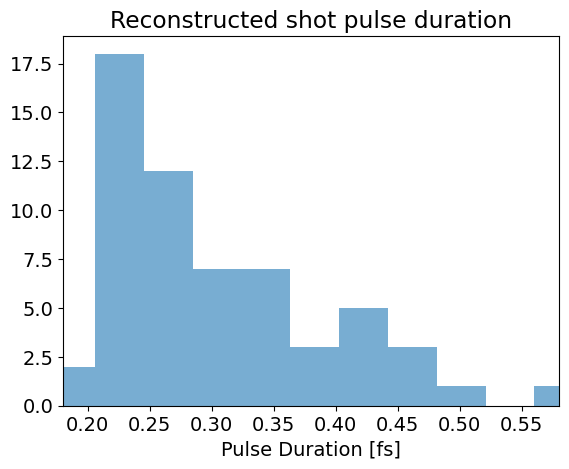

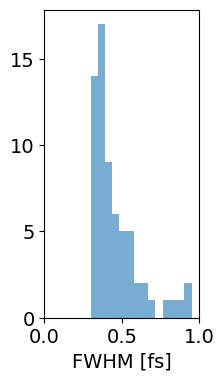

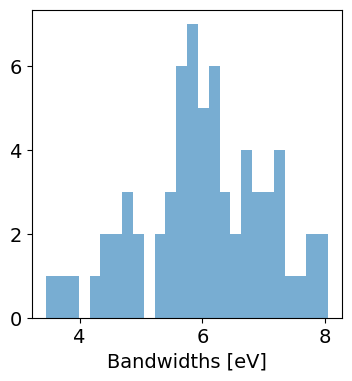

In [179]:
cut_p= fwhms2<=1.5
plt.hist(fwhms2[cut_p], alpha = 0.6, bins = 30)
plt.title('Reconstructed shot pulse duration')
plt.xlabel('Pulse Duration [fs]')
plt.xlim(0,1.2)
plt.xlim(0.18,0.58)
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim() [1])
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
# plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.show()

#fig = plt.figure(figsize = (5,4))
fig = plt.figure(figsize = (2,4))
plt.hist(fwhms[cut_p], alpha = 0.6, bins = 18)
#plt.title('FWHM of reconstructed shots')
#plt.xlabel('Pulse Duration [fs]')
plt.xlabel('FWHM [fs]')
plt.xlim(0,1.2)
plt.xlim(0.28,1)
plt.xlim(0.,1)
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
# plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.show()


fig = plt.figure(figsize = (4,4))
plt.hist(bandwidths[cut_p], alpha = 0.6, bins = 26)
#plt.title('FWHM of reconstructed shots')
plt.xlabel('Bandwidths [eV]')
#plt.xlim(0,1.2)
#plt.xlim(0.28,1)
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
# plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.show()

7.090909090909092


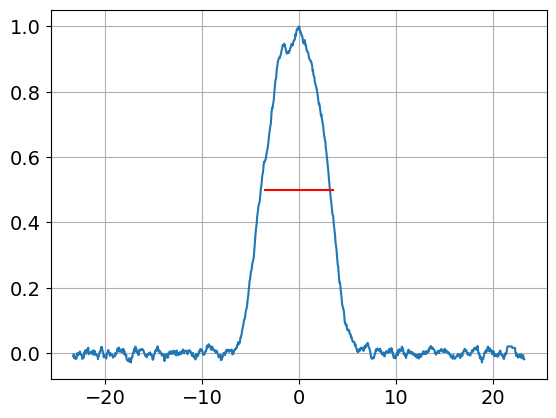

In [192]:
s = specs[50] #np.mean(specs,axis = 0)
plt.plot(xeV,np.roll(s, 512-np.argmax(s))/np.max(s))
plt.grid()
f = FWHM(xeV,s)
plt.plot([-f/2,f/2],[0.5,0.5], 'r')
print(f)

In [102]:
np.percentile(fwhms[cut_p],50)

0.3935104166666962

In [101]:
np.min(fwhms[cut_p])

0.3013958333333559

In [1]:
np.percentile(pps_trunc,50)

NameError: name 'np' is not defined

In [104]:
pps_trunc[np.argsort(-pps_trunc)]

array([0.70604545, 0.70035249, 0.63882539, 0.61705915, 0.60167955,
       0.57642624, 0.57279612, 0.54682204, 0.53649612, 0.53312234,
       0.52992556, 0.49417356, 0.49334359, 0.4453894 , 0.41045313,
       0.40554113, 0.39174316, 0.36912547, 0.35420383, 0.33890365,
       0.32977059, 0.32449908, 0.31714657, 0.28968358, 0.28475881,
       0.25758533, 0.2318994 , 0.22795723, 0.1936525 ])

In [22]:
runl = np.array(runl)
np.unique(runl)


array([112, 121, 123, 124, 125, 127])

In [76]:
np.array(pps_trunc)[np.array(runl)==127]

array([0.95861283, 0.80367149, 0.82278805, 1.01608884, 0.81049924,
       0.71423768, 0.79794497, 0.76304714, 0.93675461, 0.94618801,
       0.87262177, 0.497252  , 0.49943688, 0.45014003, 0.68448544,
       0.58623688, 0.9955468 , 0.86073295, 0.76618385, 0.48238426,
       0.45700872, 0.8605591 , 0.75080609, 0.76663152, 0.80517818,
       0.60544895])

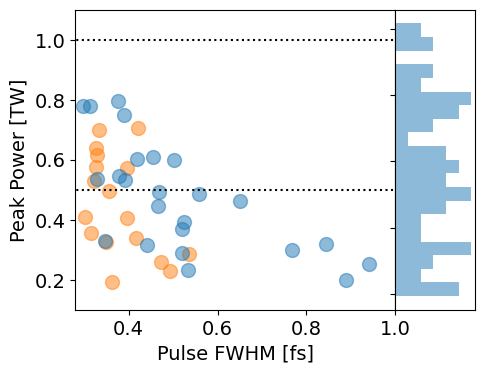

In [24]:
rect_main = [0, 0, 0.8, 1] #left, bottom, width, height
space = 0.
marg_right = [0.8+space,0, 0.2, 1]
runl = np.array(runl)

#fig = plt.figure(figsize=(7, 3)) # start with a square Figure
fig = plt.figure(figsize=(4, 3))

ax = fig.add_axes(rect_main)
ax_marg = fig.add_axes(marg_right) #, sharex=ax)

axs = [ax, ax_marg]

cols = ['tab:orange','tab:blue']
for r in np.unique(runl):
    if r < 121:
        col = cols[0]
        alph = 0.5
    else:
        col = cols[1]
        alph = 0.5
        
    if r >= 127: alph = 0
    axs[0].plot(fwhms[runl==r], pps_trunc[runl==r], 'o', markersize = 10, alpha = alph, color = col) #, bins = 30)

#axs[0].plot(fwhms[runl>=123], pps_trunc[runl>=123], 'o', markersize = 10, alpha = alph, color = col) #, bins = 30)
axs[0].set_ylabel('Peak Power [TW]')
#plt.title('Peak Power reconstructed pulses')
axs[0].set_xlabel('Pulse FWHM [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
axs[0].set_ylim(0.1,1.1)
axs[0].set_xlim(0.28,1)
axs[0].plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
axs[0].plot([0,2],[1,1], 'k:', label = '1 TW')
axs[1].set_yticklabels([])
axs[1].set_xticks([])
axs[1].hist(pps_trunc, orientation = 'horizontal', bins = 20, alpha = 0.5)
#plt.legend()
plt.show()



In [59]:
np.unique(runl)

array([112, 121, 123, 124, 125, 127])

In [72]:
np.unique(runl)

array([112, 121, 123, 124, 125, 127])

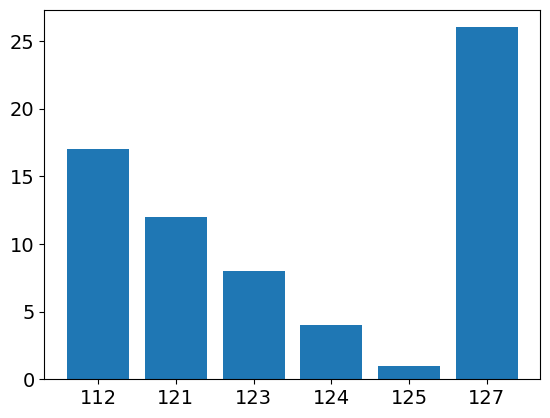

In [74]:
bins = np.unique(runl)
plt.bar(np.arange(len(bins)),[np.sum(runl==r) for r in np.unique(runl)], align = 'center', tick_label = np.unique(runl));

(0.202880859375, 0.1300048828125)

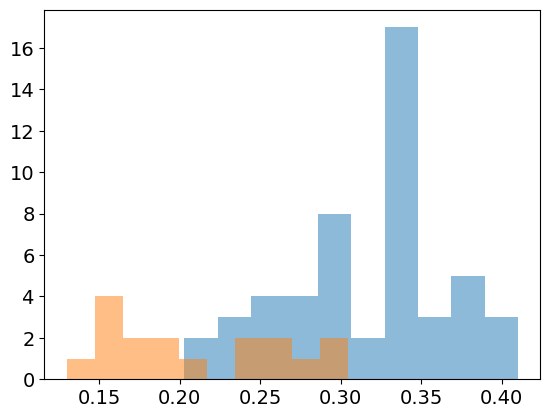

In [32]:
runl = np.array(runl)
plt.hist(gmds[runl>=121],alpha = 0.5)
plt.hist(gmds[runl<121],alpha = 0.5)
np.min(gmds[runl>=121]),np.min(gmds[runl<121])

In [33]:
runl = np.array(runl)
np.percentile(pps_trunc,50),np.percentile(pps_trunc[runl<121],50),np.percentile(pps_trunc[runl>=121],50)

(0.5598090811580639, 0.4104531329491065, 0.6016795490937608)

In [34]:
ids = np.array(ids)
ids[runl==127]

array([  3,   7,  10,  12,  13,  18,  25,  33,  38,  39,  40,  45,  51,
        59,  74,  75,  78,  79,  82,  86,  88,  89,  93, 101, 110, 113])

In [36]:
upss[runl==127]

array([0.4, 0.3, 0.7, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.9, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

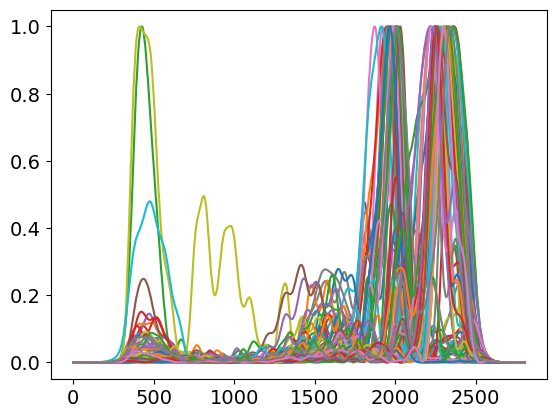

In [34]:
for i in range(len(fwhms)):
    plt.plot(ets[i])

In [70]:
i = 20
roll_to = np.argmax(ets[i])
x = ts*1e15
y = np.roll(ets[i], int(len(ets[i])/2)-roll_to)
xx = x
y1 = np.copy(y)
y1[y1<0.1*np.max(y)] = 0
y2 = np.copy(y)
y2[y2<0.3*np.max(y)] = 0
x0 = [.2, 0.2, x[np.argmax(y)], com(x,y2), .3]
res = minimize(err_func, x0, args = (xx,x,y1), method='TNC', bounds = ((0.1,3),(0.1,3),(-3,3),(-3,3),(0.05,1)), tol=1e-4)

In [71]:
x0

[0.2, 0.2, 2.997671439839845e-13, 0.025416920017655886, 0.3]

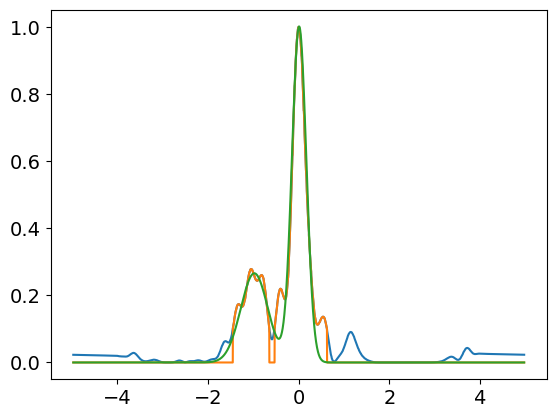

In [72]:
plt.plot(x,y)
plt.plot(x,y1)
plt.plot(xx,doubleg_gaus(xx, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4]))  #xx, sig1, sig2, x01, x02, a

In [23]:
xs = []
for i in range(len(fwhms)):
    roll_to = np.argmax(ets[i])
    x = ts*1e15
    y = np.roll(ets[i], int(len(ets[i])/2)-roll_to)
    xx = x
    y1 = np.copy(y)
    y1[y1<0.1*np.max(y)] = 0
    y2 = np.copy(y)
    y2[y2<0.3*np.max(y)] = 0
    x0 = [.2, 0.2, x[np.argmax(y)], com(x,y2), .3]
    res = minimize(err_func, x0, args = (xx,x,y1), method='TNC', bounds = ((0.1,3),(0.1,3),(-3,3),(-3,3),(0.05,1)), tol=1e-4)
    xs.append(res.x)
    # plt.plot(x,y)
    # plt.plot(x,y1)
    # plt.plot(xx,doubleg_gaus(xx, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4]))
    # plt.show()

In [24]:
xs = np.array(xs)
xs.shape

(68, 5)

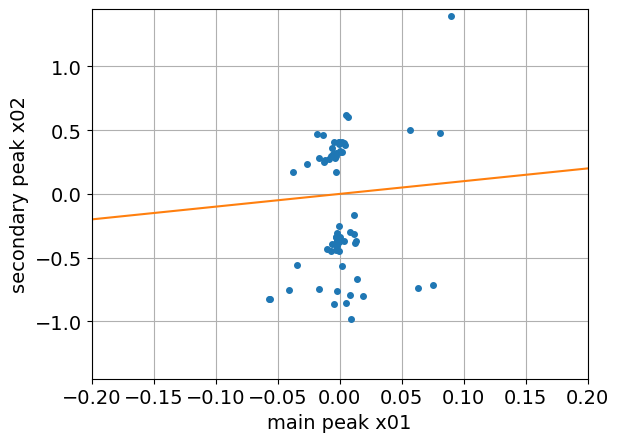

In [89]:
plt.plot(xs[:,2], xs[:,3], 'o')
plt.plot([-1,1],[-1,1])
plt.xlim(-.2,.2)
plt.ylim(-1.45,1.45)
plt.xlabel('main peak x01')
plt.ylabel('secondary peak x02')
plt.grid()

(array([12.,  6., 10.,  3.,  9.,  6.,  2.,  7.,  5.,  8.]),
 array([ 0.        ,  4.94493375,  9.88986749, 14.83480124, 19.77973499,
        24.72466873, 29.66960248, 34.61453622, 39.55946997, 44.50440372,
        49.44933746]),
 <BarContainer object of 10 artists>)

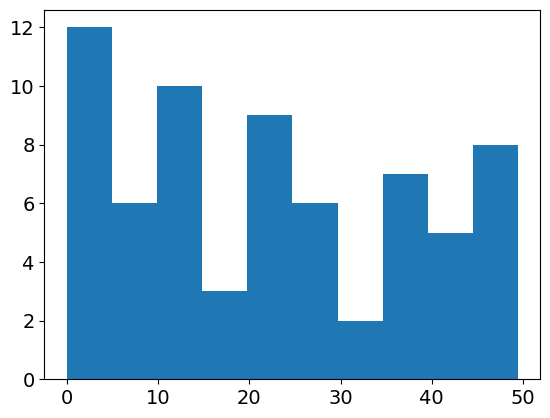

In [27]:
std_ts = np.array(std_ts)
plt.hist(std_ts)

18 8


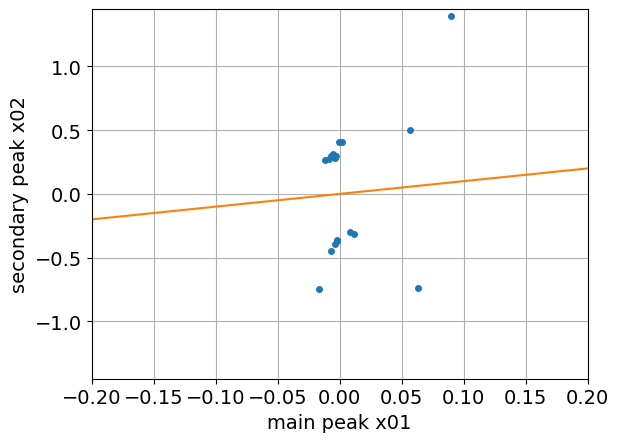

In [99]:
cut_std_ts = 10
plt.plot(xs[:,2][std_ts<cut_std_ts], xs[:,3][std_ts<cut_std_ts], 'o')
plt.plot([-1,1],[-1,1])
plt.xlim(-.2,.2)
plt.ylim(-1.45,1.45)
plt.xlabel('main peak x01')
plt.ylabel('secondary peak x02')
plt.grid()
dif = xs[:,2][std_ts<cut_std_ts]-xs[:,3][std_ts<cut_std_ts]
print(len(dif),np.sum(dif>0))

(array([27.,  6., 10.,  2.,  9.,  6.,  4.,  3.,  0.,  1.]),
 array([0.00000000e+00, 7.25554905e-17, 1.45110981e-16, 2.17666471e-16,
        2.90221962e-16, 3.62777452e-16, 4.35332943e-16, 5.07888433e-16,
        5.80443924e-16, 6.52999414e-16, 7.25554905e-16]),
 <BarContainer object of 10 artists>)

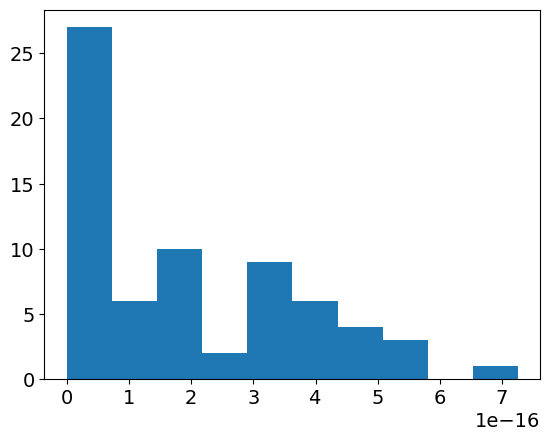

In [26]:
std_ws = np.array(std_ws)
plt.hist(std_ws)

21 15


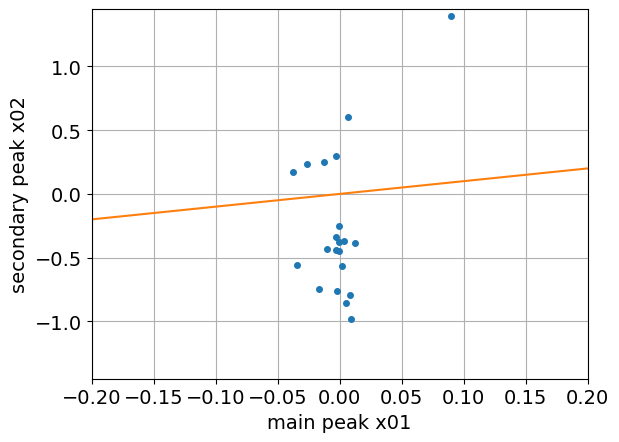

In [109]:
cut_std_ws = .1e-16
plt.plot(xs[:,2][std_ws<cut_std_ws], xs[:,3][std_ws<cut_std_ws], 'o')
plt.plot([-1,1],[-1,1])
plt.xlim(-.2,.2)
plt.ylim(-1.45,1.45)
plt.xlabel('main peak x01')
plt.ylabel('secondary peak x02')
plt.grid()
dif = xs[:,2][std_ws<cut_std_ws]-xs[:,3][std_ws<cut_std_ws]
print(len(dif),np.sum(dif>0))

18 13


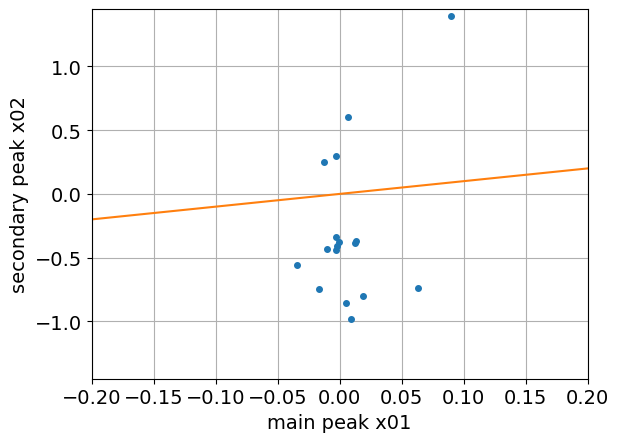

In [28]:
cut_std_ws = 1e-16
cut_std_ts = 30

plt.plot(xs[:,2][(std_ws<cut_std_ws)&(std_ts<cut_std_ts)], xs[:,3][(std_ws<cut_std_ws)&(std_ts<cut_std_ts)], 'o')
plt.plot([-1,1],[-1,1])
plt.xlim(-.2,.2)
plt.ylim(-1.45,1.45)
plt.xlabel('main peak x01')
plt.ylabel('secondary peak x02')
plt.grid()
dif = xs[:,2][(std_ws<cut_std_ws)&(std_ts<cut_std_ts)]-xs[:,3][(std_ws<cut_std_ws)&(std_ts<cut_std_ts)]
print(len(dif),np.sum(dif>0))

Text(0, 0.5, 'Counts')

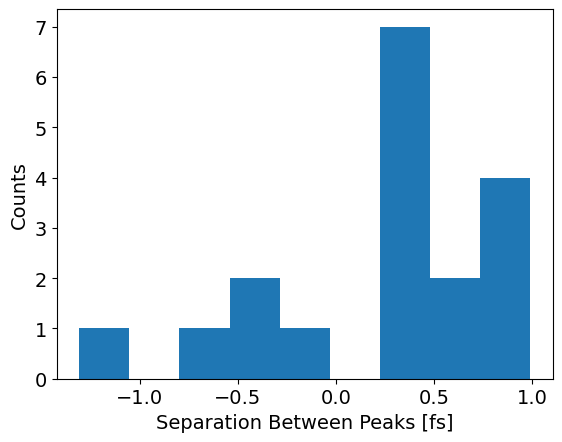

In [48]:
plt.hist(dif,bins=9)
plt.xlabel('Separation Between Peaks [fs]')
plt.ylabel('Counts')

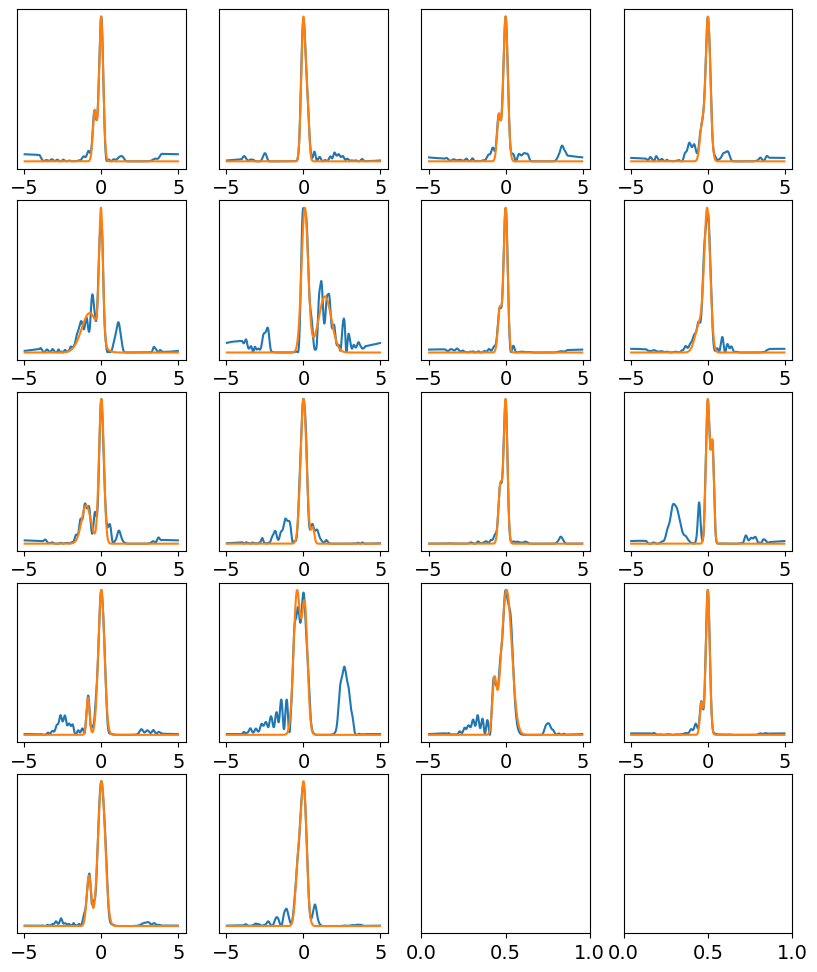

In [144]:
fig,axs = plt.subplots(nrows = 5,ncols = 4, figsize = (10,12))
axs = axs.flatten()
for i in range(len(xs[:,2][(std_ws<cut_std_ws)&(std_ts<cut_std_ts)])):
    roll_to = np.argmax(ets[(std_ws<cut_std_ws)&(std_ts<cut_std_ts)][i])
    x = ts*1e15
    y = np.roll(ets[(std_ws<cut_std_ws)&(std_ts<cut_std_ts)][i], int(len(ets[(std_ws<cut_std_ws)&(std_ts<cut_std_ts)][i])/2)-roll_to)
    xx = x
    y1 = np.copy(y)
    y1[y1<0.1*np.max(y)] = 0
    y2 = np.copy(y)
    y2[y2<0.3*np.max(y)] = 0
    x0 = [.2, 0.2, x[np.argmax(y)], com(x,y2), .3]
    res = minimize(err_func, x0, args = (xx,x,y1), method='TNC', bounds = ((0.1,3),(0.1,3),(-3,3),(-3,3),(0.05,1)), tol=1e-4)
    axs[i].plot(x,y)
    #plt.plot(x,y1)
    axs[i].set_yticks([])
    axs[i].plot(xx,doubleg_gaus(xx, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4]))
    #plt.show()
    
    axs[-1].set_yticks([])
    axs[-2].set_yticks([])

In [87]:
dif = xs[:,2]-xs[:,3]
np.sum(dif>0)

37

In [1]:
np.sum(dif<0)

NameError: name 'np' is not defined

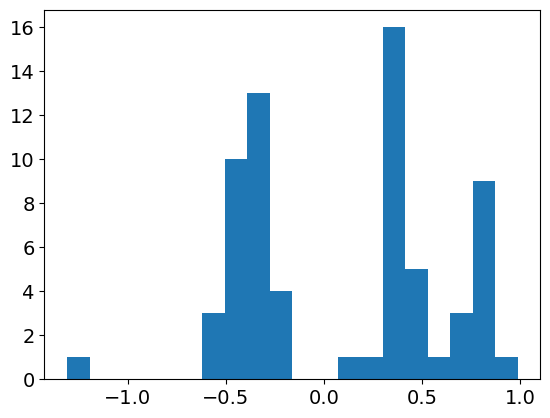

In [82]:
plt.hist(xs[:,2]-xs[:,3], bins = 20); #positive means tail on left

In [262]:
np.argmin((fwhms-0.9245)**2)

53

In [256]:
np.array(fwhms)[runl==127]

array([0.34781667, 0.34641667, 0.40808333, 0.30771667, 0.33793333,
       0.3478    , 0.41718333, 0.40391667, 0.32806667, 0.33978333,
       0.3891    , 0.92453333, 0.63918333, 0.68215   , 0.38171667,
       0.47976667, 0.37848333, 0.36506667, 0.38911667, 0.5513    ,
       0.60063333, 0.35581667, 0.59385   , 0.5328    , 0.35766667,
       0.45695   ])

In [201]:
np.percentile(pps_trunc, 50)

0.5598090811580639

In [203]:
pps_trunc[np.argsort(-pps_trunc)]

array([1.01608884, 0.9955468 , 0.95861283, 0.94618801, 0.93675461,
       0.87262177, 0.86073295, 0.8605591 , 0.82278805, 0.81049924,
       0.80517818, 0.80367149, 0.79794497, 0.79722371, 0.78014781,
       0.77953999, 0.76663152, 0.76618385, 0.76304714, 0.75080609,
       0.7503968 , 0.71423768, 0.70604545, 0.70035249, 0.68448544,
       0.63882539, 0.61705915, 0.60982011, 0.60544895, 0.60167955,
       0.59866866, 0.58623688, 0.57642624, 0.57279612, 0.54682204,
       0.53649612, 0.53312234, 0.52992556, 0.49943688, 0.497252  ,
       0.49417356, 0.49334359, 0.48700498, 0.48238426, 0.46278976,
       0.45700872, 0.45014003, 0.4453894 , 0.41045313, 0.40554113,
       0.39174316, 0.36912547, 0.35420383, 0.33890365, 0.32977059,
       0.32449908, 0.32068083, 0.31714657, 0.29888656, 0.28968358,
       0.28475881, 0.25758533, 0.25078659, 0.2318994 , 0.23015899,
       0.22795723, 0.20020465, 0.1936525 ])

In [200]:
np.percentile(fwhms, 50)

0.40044791666669666

In [35]:
np.percentile(fwhms*bandwidths, 50)

2.9263738636365426

In [36]:
2.9/1.8

1.611111111111111

In [40]:
1.8/13*1.6


0.22153846153846157

In [41]:
150/220  #median energy

0.6818181818181818

(1.5, 7.5)

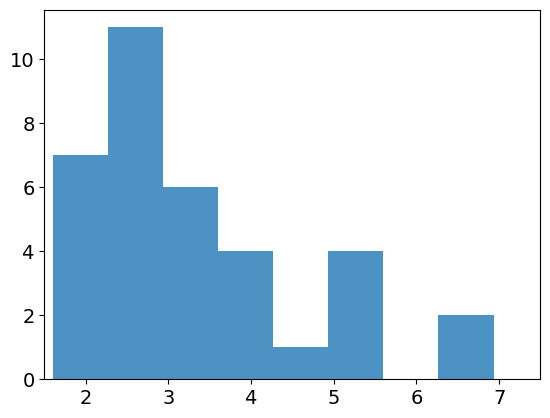

In [53]:
plt.hist(fwhms*bandwidths, bins = 35, alpha = 0.8);
plt.xlim(1.5,7.5)

In [130]:
runl = np.array(runl)

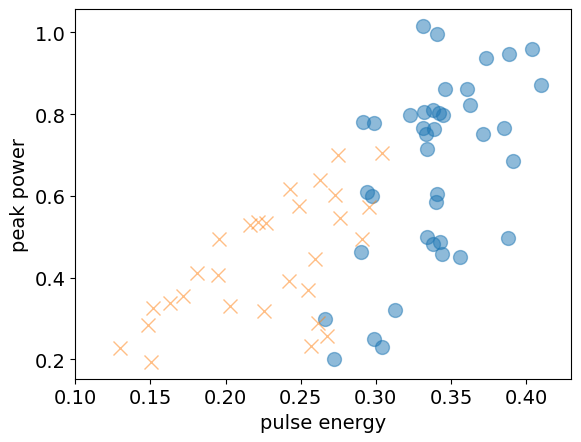

(array([ 0.,  0.,  8., 12.,  9.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 <BarContainer object of 9 artists>)

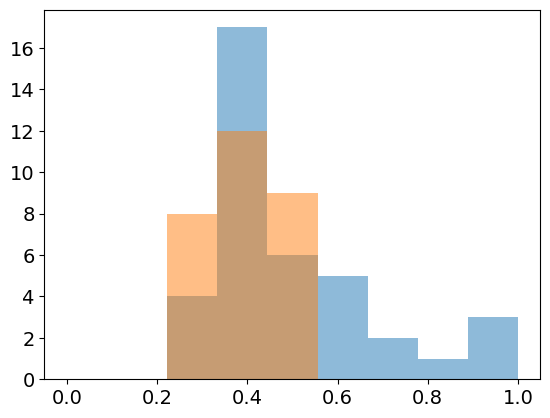

In [300]:
plt.plot(gmds[runl>=123],pps_trunc[runl>=123], 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.plot(gmds[runl<123],pps_trunc[runl<123], 'x', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('peak power')
plt.xlabel('pulse energy')
#plt.plot([0,0.45],[1.8,1.8],'k:')
#plt.ylim(0,8)
plt.xlim(0.1,0.43)
plt.show()

plt.hist(fwhms[runl>=123],alpha = 0.5, bins = np.linspace(0,1,10)) #, bins = 30)
plt.hist(fwhms[runl<123], alpha = 0.5,bins = np.linspace(0,1,10)) #, bins = 30)

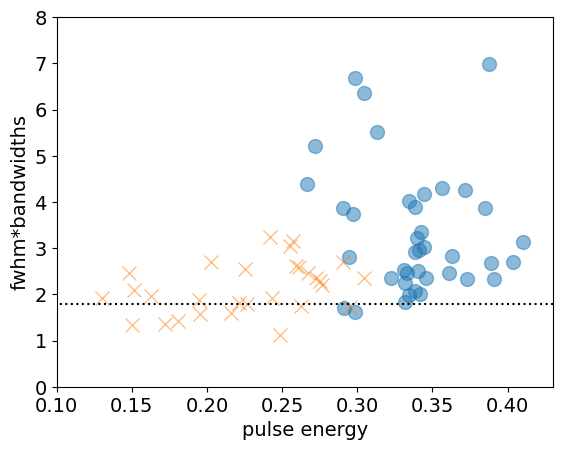

In [131]:
plt.plot(gmds[runl>=123],fwhms[runl>=123]*bandwidths[runl>=123], 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.plot(gmds[runl<123],fwhms[runl<123]*bandwidths[runl<123], 'x', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('fwhm*bandwidths')
plt.xlabel('pulse energy')
plt.plot([0,0.45],[1.8,1.8],'k:')
plt.ylim(0,8)
plt.xlim(0.1,0.43)
plt.show()

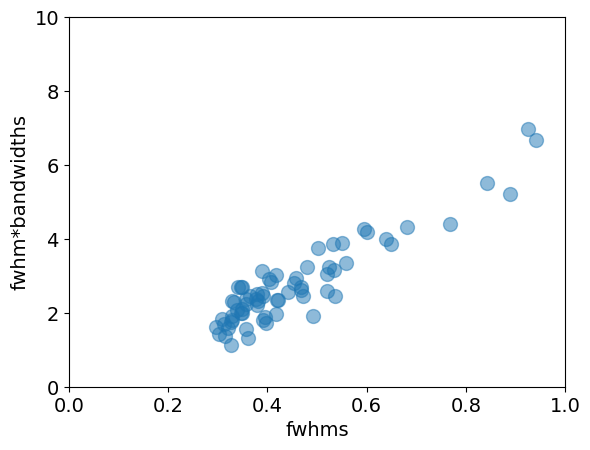

In [28]:
plt.plot(fwhms,fwhms*bandwidths, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('fwhm*bandwidths')
plt.xlabel('fwhms')
plt.xlim(0,1)
plt.ylim(0,10)
plt.show()

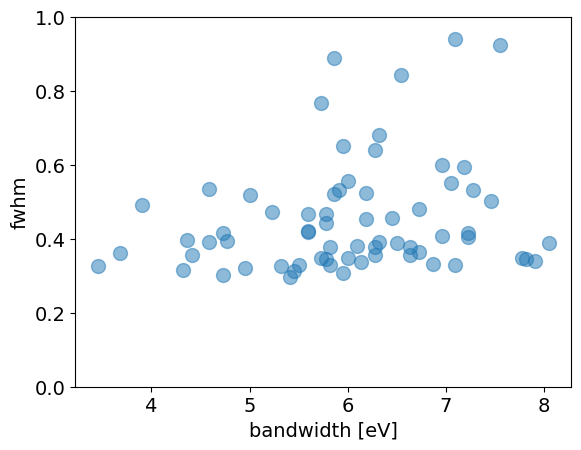

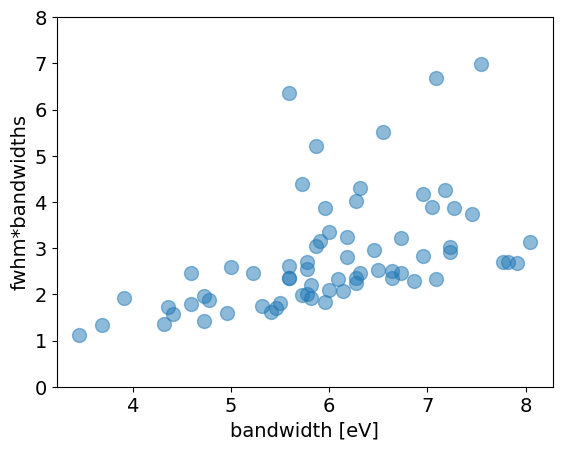

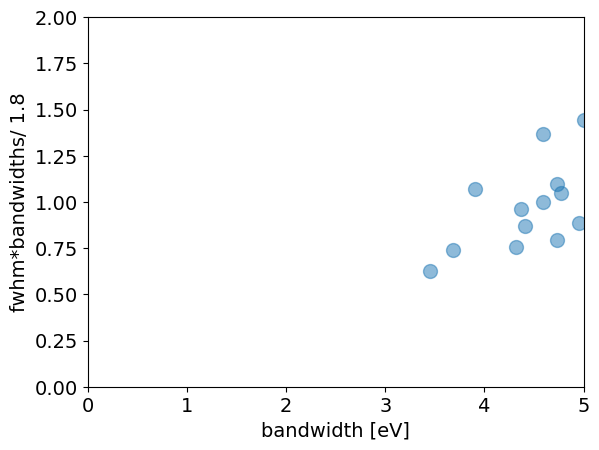

In [193]:
plt.plot(bandwidths,fwhms, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('fwhm')
plt.xlabel('bandwidth [eV]')
plt.ylim(0,1)
plt.show()

plt.plot(bandwidths,fwhms*bandwidths, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('fwhm*bandwidths')
plt.xlabel('bandwidth [eV]')
plt.ylim(0,8)
plt.show()

plt.plot(bandwidths,fwhms*bandwidths/1.8, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('fwhm*bandwidths/ 1.8')
plt.xlabel('bandwidth [eV]')
plt.ylim(0,2)
plt.xlim(0,5)
plt.show()

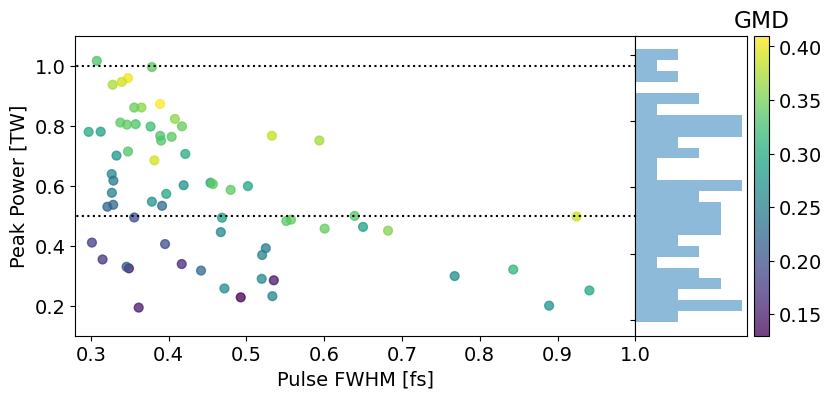

In [24]:
rect_main = [0, 0, 0.8, 1] #left, bottom, width, height
space = 0.
marg_right = [0.8+space,0, 0.2, 1]


fig = plt.figure(figsize=(7, 3)) # start with a square Figure

ax = fig.add_axes(rect_main)
ax_marg = fig.add_axes(marg_right) #, sharex=ax)

axs = [ax, ax_marg]

p = axs[0].scatter(fwhms, pps_trunc, s = 40, c = gmds, alpha = 0.75) #, bins = 30)
axs[0].set_ylabel('Peak Power [TW]')
#plt.title('Peak Power reconstructed pulses')
axs[0].set_xlabel('Pulse FWHM [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
axs[0].set_ylim(0.1,1.1)
axs[0].set_xlim(0.28,1)
axs[0].plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
axs[0].plot([0,2],[1,1], 'k:', label = '1 TW')
axs[1].set_yticklabels([])
axs[1].set_xticks([])
axs[1].hist(pps_trunc, orientation = 'horizontal', bins = 25, alpha = 0.5)
clb = plt.colorbar(p, ax = axs[1])
clb.ax.set_title('GMD')
#plt.legend()
plt.show()

In [29]:
1.8e-6/3e8

6e-15

In [30]:
vNaxis['t']

array([-2.99768519e-15, -2.82638889e-15, -2.65509259e-15, -2.48379630e-15,
       -2.31250000e-15, -2.14120370e-15, -1.96990741e-15, -1.79861111e-15,
       -1.62731481e-15, -1.45601852e-15, -1.28472222e-15, -1.11342593e-15,
       -9.42129630e-16, -7.70833333e-16, -5.99537037e-16, -4.28240741e-16,
       -2.56944444e-16, -8.56481481e-17,  8.56481481e-17,  2.56944444e-16,
        4.28240741e-16,  5.99537037e-16,  7.70833333e-16,  9.42129630e-16,
        1.11342593e-15,  1.28472222e-15,  1.45601852e-15,  1.62731481e-15,
        1.79861111e-15,  1.96990741e-15,  2.14120370e-15,  2.31250000e-15,
        2.48379630e-15,  2.65509259e-15,  2.82638889e-15,  2.99768519e-15])

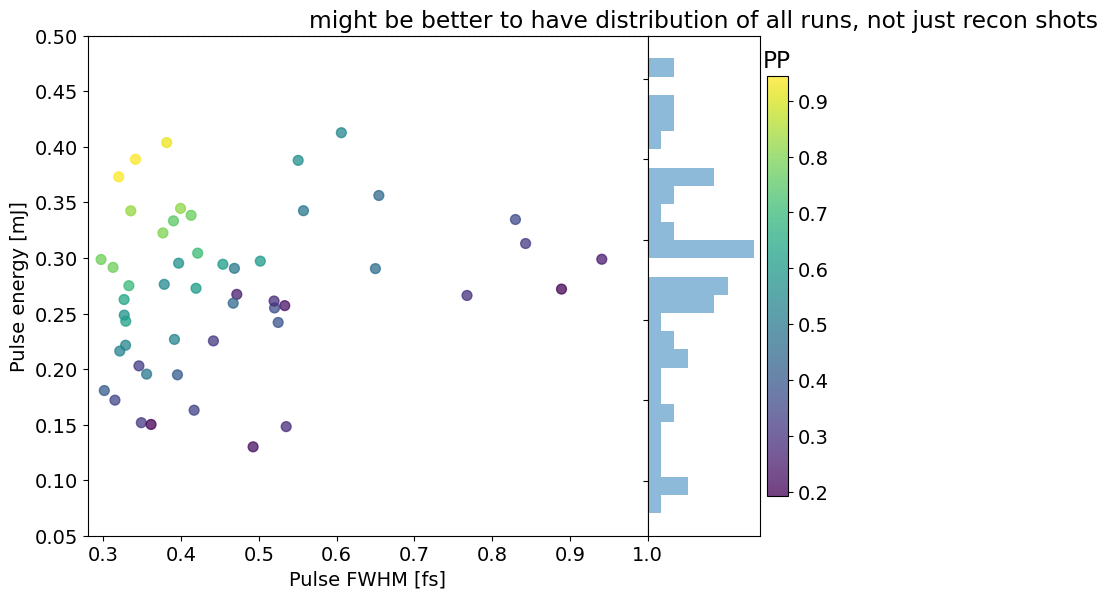

In [279]:
rect_main = [0, 0, 0.8, 1] #left, bottom, width, height
space = 0.
marg_right = [0.8+space,0, 0.2, 1]


fig = plt.figure(figsize=(7, 5)) # start with a square Figure

ax = fig.add_axes(rect_main)
ax_marg = fig.add_axes(marg_right) #, sharex=ax)

axs = [ax, ax_marg]

p = axs[0].scatter(fwhms, gmds, s = 50, c = pps_trunc, alpha = 0.75) #, bins = 30)
axs[0].set_ylabel('Pulse energy [mJ]')
#plt.title('Peak Power reconstructed pulses')
axs[0].set_xlabel('Pulse FWHM [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
axs[0].set_ylim(0.05,0.5)
axs[0].set_xlim(0.28,1)
axs[0].plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
axs[0].plot([0,2],[1,1], 'k:', label = '1 TW')
axs[1].set_yticklabels([])
axs[1].set_xticks([])
axs[1].hist(gmds, orientation = 'horizontal', bins = 25, alpha = 0.5)
axs[1].set_title('might be better to have distribution of all runs, not just recon shots')
clb = plt.colorbar(p, ax = axs[1])
clb.ax.set_title('PP')
#plt.legend()
plt.show()

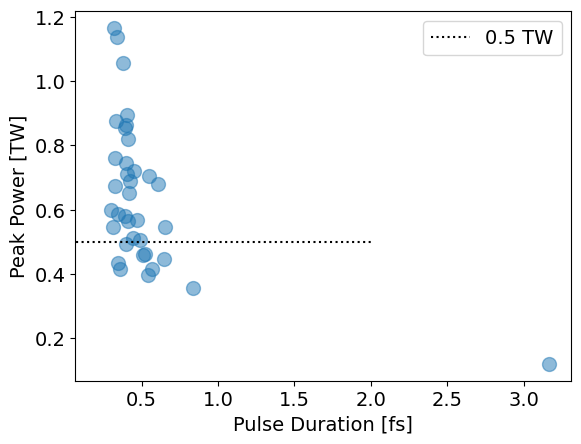

In [40]:
plt.plot(fwhms, gmds/fwhms, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power [TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

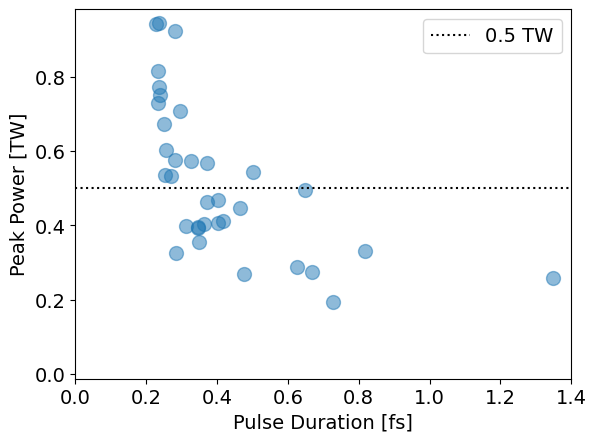

In [41]:
plt.plot(fwhms2, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power [TW]')
#plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.xlim(0.,1.4)
plt.show()

In [324]:
test[['run', 'ID', 'Qb']]

array([(121, 6, False)],
      dtype={'names': ['run', 'ID', 'Qb'], 'formats': ['<i8', '<i8', '?'], 'offsets': [0, 16, 849], 'itemsize': 850})

In [ ]:
GMD = A times integral of pulse dt
peak power = 1/A

In [61]:
def peak_power(EtEt, ts,  gmd):
    EtEt = EtEt/np.sum(EtEt)
    dt_flat = np.trapz(EtEt,1e15*ts)/np.max(EtEt)
    #print(dt_flat)
    PP = gmd/dt_flat
    return PP

    

0.7023443371703664

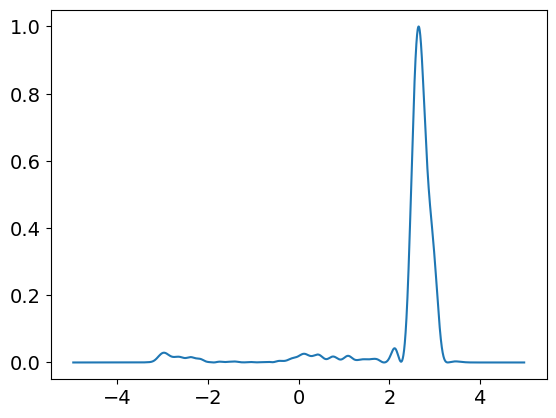

In [62]:
nn= 46
# t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
# t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)
look =  (datall['run'] == runl[nn])& (datall['ID'] == ids[nn]) & (datall['Up'] == upss[nn]) & (datall['gmd'] == gmds[nn]) & (datall['Qb'])
datlook = datall[look]
Q = np.squeeze(datlook['Qs'][0])
N_basis = 36
eVshift_idx = 0
Q1=Q[0:N_basis]
Q1=np.reshape(Q1,[1,N_basis])
Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
Q2=np.reshape(Q2,[1,N_basis])
Qguess=Q1+1j*Q2
Qguess=np.reshape(Qguess,[N_basis,1])


alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
#alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

EtEt = np.abs(Et*Et.conj())
EtEt = EtEt/np.max(EtEt)
plt.plot(1e15*vNaxis['t_sample'],EtEt)
peak_power(EtEt, vNaxis['t_sample'], gmds[nn])

0.9444770543423595

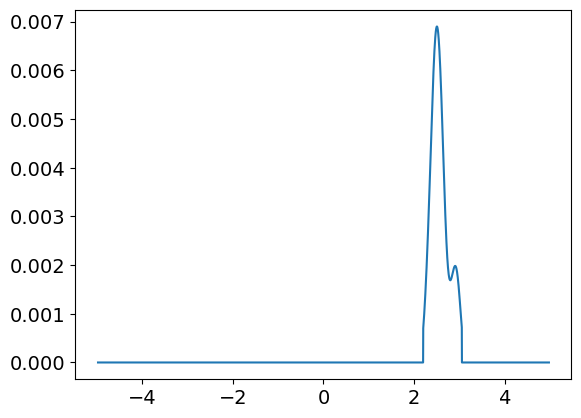

In [92]:
EtEt = EtEt/np.sum(EtEt)
EtEt[EtEt<0.1*np.max(EtEt)] = 0
plt.plot(1e15*vNaxis['t_sample'],EtEt)

peak_power(EtEt,vNaxis['t_sample'], gmds[nn])

In [85]:
pps_trunc[46]

0.9444770543423595

In [86]:
dt_flat = np.trapz(EtEt,1e15*vNaxis['t_sample'])/np.max(EtEt)
PP = gmds[nn]/dt_flat
PP*dt_flat

0.3887939453125

In [55]:
np.max(EtEt*PP)

0.003194456281730448

In [340]:
gmds[nn]/fwhms2[nn]

0.7508227457838818

In [174]:
print(datall[cut][188]['gmd'],datall[cut][188]['std_t'],datall[cut][188]['fwhm2'],datall[cut][188]['fwhm'])

0.333984375 121.82709178496788 0.3854166666666955 0.31141666666669


In [228]:
print(gmds[24], fwhms2[24], fwhms[24])

0.2952880859375 0.41239583333336416 0.3969791666666964


In [42]:
np.argsort(-gmds/fwhms2)

array([37, 52, 58, 41,  8,  2, 62, 20, 53, 34, 22, 50, 29, 30, 35, 18, 10,
        4,  9, 26, 11, 17, 67, 33, 21, 46, 66, 48, 60, 23, 31, 19, 61, 42,
        5, 28, 13, 55, 43, 63, 36, 44, 25, 45, 65, 27, 49,  3, 32, 56, 51,
        7, 40,  0, 14, 57, 12, 64,  6, 16, 24, 15,  1, 39, 47, 54, 59, 68,
       38])

In [298]:
np.argsort(fwhms2)

array([28, 33, 40, 27, 37,  2, 38, 41, 39, 31,  9, 10, 15, 29, 18,  1, 35,
        3, 25, 14,  5, 11,  4, 20, 42, 30, 13,  0,  6, 32, 43, 23, 34, 22,
       36, 26,  7, 12, 24, 21, 17, 16,  8, 19, 44])

In [297]:
np.argsort(-pps)

array([41, 40, 35, 38, 33, 28, 39, 27, 37, 31,  2, 42, 25, 29,  1, 18,  9,
        5, 34, 10, 32, 15, 43, 20, 14, 30, 11, 36,  6,  0, 13, 12, 22, 19,
       23,  4, 44, 16,  3, 26,  8, 24, 17, 21,  7])

In [519]:
t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)
t1 = 0
t2 = -1

In [28]:
len(alphas)

2

In [32]:
np.sum(alphas[0]['t']-alphas[-1]['t'])

0j

In [359]:
pps_trunc[40]

0.6700057855654937

In [354]:
np.argsort((fwhms2-1.75)**2)

array([40, 31, 29, 37, 25,  7,  6, 44, 36, 24, 26, 20, 12, 41, 28, 10, 43,
        4, 38, 35,  9, 11, 16, 33,  1,  2,  5, 14, 47, 17,  3, 48, 19, 15,
       32,  0, 27, 18, 13, 23, 39,  8, 22, 46, 21, 42, 30, 49, 34, 45])

In [340]:
print(np.max(pps),np.max(pps_trunc))

0.6937524809802568 0.773111940350741


In [238]:
np.argsort(-fwhms)

array([32, 34, 53, 29, 30, 31, 55, 38, 54, 62, 64, 40, 61, 11, 25, 65, 19,
       21, 24, 37, 13, 57,  8, 28, 22, 67, 33, 27,  2, 18, 48, 10, 44, 49,
        5,  0, 26, 39, 60, 52, 56, 58, 23, 41, 59,  7, 66, 16, 63,  3, 42,
       47, 43, 20, 51, 46, 12, 14, 17, 50,  1,  9, 15,  4, 36, 45,  6, 35])

In [234]:
np.argsort(fwhms2)

array([45, 58, 36, 16, 63, 12, 41, 51, 50, 14, 35, 46,  2, 66, 48, 49, 60,
       59, 39,  9, 15, 44, 43, 17, 18, 42, 52, 23, 37, 26, 10,  1,  3, 33,
       11, 65, 47, 13, 22, 67,  5, 57, 64, 19,  4, 28, 54, 38, 21, 56,  0,
        6, 61, 40, 62, 55, 53, 31, 30, 34,  7, 20, 32, 29, 25, 24,  8, 27])

In [233]:
np.argsort(-pps_trunc)

array([45, 58, 42, 51, 50, 52, 59, 63, 44, 46, 66, 43, 48, 41, 36, 35, 65,
       60, 49, 64, 39, 47,  2, 12, 56,  9, 14, 33, 67, 18, 37, 57,  1,  5,
       23, 17, 26, 15, 54, 53, 16, 28, 40, 61, 38, 62, 55, 22,  6,  0, 19,
       21,  4, 10, 20,  3, 30, 27, 31, 24, 11,  8, 34, 25, 32, 13, 29,  7])

In [77]:
np.argsort((1-fwhms/fwhms2)**2)

array([29,  0, 56,  4, 47,  1,  5,  3,  6, 35, 62, 28, 17, 15, 61, 40, 21,
        9, 34, 32, 42, 43, 67, 14, 23, 55, 50, 22, 26, 57, 46, 30, 52, 51,
       25, 12, 10,  7, 24, 36, 59, 19, 66, 13, 31, 20, 33, 39, 60, 44, 18,
        8, 63, 41, 49, 16, 54, 64, 38, 48, 27, 65,  2, 11, 45, 37, 53, 58])

In [82]:
np.argsort(-upss)

array([18,  8,  3, 58,  7,  0, 19, 13, 41, 10,  5,  1, 44, 26, 27, 46, 39,
       36, 34, 32, 30, 47, 33,  6,  9, 20, 17, 16,  4, 48, 49, 50, 51, 52,
       53, 54, 45, 56, 59, 60, 61, 62, 63, 64, 65, 55, 57, 67, 42, 11, 38,
       35, 66, 43, 24, 25, 21, 28, 29, 31, 15, 22, 14, 37, 12, 40,  2, 23])

4
4
5
5
4
5
5
5
5
5


Text(0.5, 0, 't [fs]')

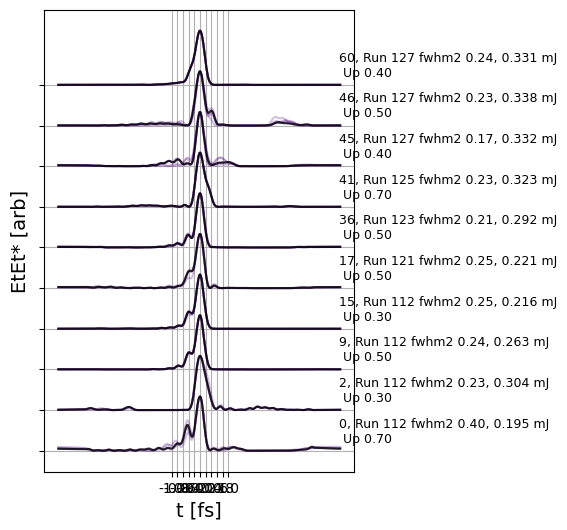

In [291]:
t1 = 0
t2 = -1
#[3, 0, 5, 6, 7, 1, 2, 4]#
nns = [2, 1, 5, 6, 0, 4, 3, 8, 7] #
nns = [35, 36, 4, 48,49,36,15] #[61,  95, 101,  88,  17] #[52, 37, 58, 62, 11] #[37, 52, 58, 41,  8] #[58] # [37, 52, 58, 41,  8]
nns = [0,2,9, 15, 17, 36, 41,45, 46,60]#53,37,2,45,36,16,63,12,41,51]
# nns = [45,58,42]
# nns = [53,55,54, 62, 64,]
spacer = 1.2
sc = 1.6
fig,axs = plt.subplots(figsize = (4,6))
for b,nn in enumerate(nns):
    look = (datall['run'] == runl[nn])&(datall['ID'] == ids[nn]) & (datall['Up'] == upss[nn]) & (datall['gmd'] == gmds[nn]) 
    datlook = datall[look]
    print(len(datlook))



    ets = []
    for i in range(len(datlook)):
        Q = np.squeeze(datlook['Qs'][i])
        N_basis = 36
        eVshift_idx = 0
        Q1=Q[0:N_basis]
        Q1=np.reshape(Q1,[1,N_basis])
        Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
        Q2=np.reshape(Q2,[1,N_basis])
        Qguess=Q1+1j*Q2
        Qguess=np.reshape(Qguess,[N_basis,1])


        alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
        #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
        Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

        EtEt = np.abs(Et*Et.conj())
        EtEt = EtEt/np.max(EtEt)
        #EtEt[EtEt<0.1*np.max(EtEt)] = 0
        ets.append(EtEt)
        roll_to = np.argmax(EtEt[t1:t2])
        axs.plot(1e15*vNaxis['t_sample'][t1:t2], sc*(np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))+b*spacer, color = 'indigo', alpha = 0.25) #, label = i)

    mostlike = np.argmax(datlook['Qb'])
    roll_to = np.argmax(ets[mostlike][t1:t2])
    axs.plot(1e15*vNaxis['t_sample'][t1:t2], sc*(np.roll(ets[mostlike][t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))+b*spacer, 'k', alpha = 0.8) #, label = i)
    axs.text(4.9, b*spacer+0.25, '%1.0f, Run %1.0f fwhm2 %1.2f, %1.3f mJ\n Up %1.2f' %(nn, runl[nn],fwhms2[nn],gmds[nn],upss[nn]), fontsize = 9)
#plt.legend()
plt.grid()
plt.yticks(np.arange(len(nns))*spacer,[]);
plt.xticks(np.arange(-1,1.2,0.2), ['%1.1f' %x for x in np.arange(-1,1.2,0.2)], fontsize = 10)
plt.ylabel('EtEt* [arb]')
plt.xlabel('t [fs]')

#plt.xlim(-1,1.)
#plt.xticks
#plt.title('gmd = %1.3f' %gmds[nn])

In [289]:
print('run', np.array(runl)[nns])
print('ID',np.array(ids)[nns])

run [112 112 112 112 121 123 125 127 127 127]
ID [ 33 114 171 195   8  95  13  12  13  82]


In [287]:
np.array(ids)[nns]

array([ 33, 114, 171, 195,   8,  95,  13,  12,  13,  82])

In [286]:
np.array(pps_trunc)[nns]

array([0.40554113, 0.70604545, 0.63882539, 0.52992556, 0.53649612,
       0.78014781, 0.79722371, 1.01608884, 0.81049924, 0.76618385])

In [271]:
np.array(fwhms)[nns]

array([0.92453333, 0.68215   , 0.63918333, 0.60063333, 0.59385   ])

In [35]:
len(np.unique(ids))

63

In [32]:
np.array(ids)[np.where(127 == np.array(runl))[0]]

array([  3,   7,  10,  12,  13,  18,  25,  33,  38,  39,  40,  45,  51,
        59,  74,  75,  78,  79,  82,  86,  88,  89,  93, 101, 110, 113])

In [146]:
np.unique(np.array(runl)[nns])

array([112, 123, 124, 125, 127])

In [144]:
np.unique(datall['run'])

array([110, 112, 121, 122, 123, 124, 125, 127])

4
4
5
5
4
5
5
5
5
5


(-3.5, 3.5)

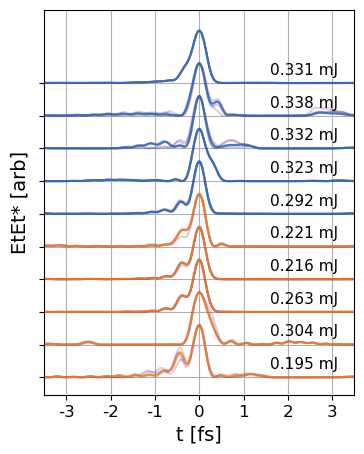

In [295]:
#fig,axs = plt.subplots(figsize = (5,7))
fig,axs = plt.subplots(figsize = (4,5))
spacer = 1.
sc = 1.6
for b,nn in enumerate(nns):
    look = (datall['run'] == runl[nn])&(datall['ID'] == ids[nn]) & (datall['Up'] == upss[nn]) & (datall['gmd'] == gmds[nn]) 
    datlook = datall[look]
    print(len(datlook))



    ets = []
    for i in range(len(datlook)):
        Q = np.squeeze(datlook['Qs'][i])
        N_basis = 36
        eVshift_idx = 0
        Q1=Q[0:N_basis]
        Q1=np.reshape(Q1,[1,N_basis])
        Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
        Q2=np.reshape(Q2,[1,N_basis])
        Qguess=Q1+1j*Q2
        Qguess=np.reshape(Qguess,[N_basis,1])


        alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
        #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
        Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

        EtEt = np.abs(Et*Et.conj())
        EtEt = EtEt/np.max(EtEt)
        #EtEt[EtEt<0.1*np.max(EtEt)] = 0
        ets.append(EtEt)
        roll_to = np.argmax(EtEt[t1:t2])
        axs.plot(1.0e15*vNaxis['t_sample'][t1:t2], sc*(np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))+b*spacer, color = 'indigo', alpha = 0.2) #, label = i)

    mostlike = np.argmax(datlook['Qb'])
    roll_to = np.argmax(ets[mostlike][t1:t2])
    if runl[nn] < 123: cc = 'tab:orange'
    else: cc = 'tab:blue'
    axs.plot(1e15*vNaxis['t_sample'][t1:t2], sc*(np.roll(ets[mostlike][t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))+b*spacer, color = cc, alpha = 0.8) #, label = i)
    #axs.text(1.2, b*spacer+0.25, 'Run %1.0f\nfwhm2 %1.2f\n%1.3f mJ' %(runl[nn],fwhms2[nn],gmds[nn]), fontsize = 9)
    axs.text(1.6, b*spacer+0.26, '%1.3f mJ' %(gmds[nn]), fontsize = 11)
#plt.legend()
plt.grid()
plt.ylim(axs.get_ylim()[0],axs.get_ylim()[-1]*1.01)
plt.yticks(np.arange(len(nns))*spacer,[]);
xs = np.arange(-3,3.1,1)
plt.xticks(xs, ['%1.0f' %x for x in xs], fontsize = 12)
plt.ylabel('EtEt* [arb]') 
plt.xlabel('t [fs]')
plt.xlim(xs[0]-.5,xs[-1]+.5)
#plt.xticks
#plt.title('gmd = %1.3f' %gmds[nn])

In [273]:
1.85e-6/3e8

6.166666666666667e-15

In [69]:
vNaxis['t'][0]*2

-5.99537037037037e-15

In [30]:
np.array(ids)[runl==112]

array([ 33, 102, 114, 121, 127, 129, 139, 155, 169, 171, 175, 177, 184,
       191, 194, 195, 202])

In [283]:
datlook[0].dtype.names

('run',
 'seed',
 'ID',
 'Up',
 'Qs',
 'costs',
 'costM',
 'std_t',
 'fwhm2',
 'fwhm',
 'gmd',
 'Upb',
 'peak_power',
 'Qb',
 'spec')

In [284]:
roll_to

1996

5
5
5
5
5


Text(0.5, 1.0, "w0 isn't being saved per shot")

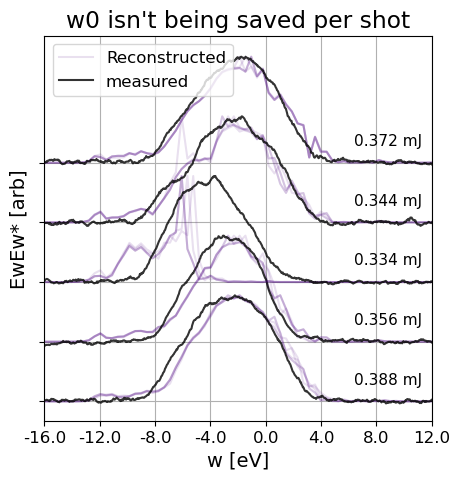

In [274]:
fig,axs = plt.subplots(figsize = (5,5))
spacer = 0.9
sc = 1.6
pixpereV = 22
xeV = pix_2_eV(np.arange(1024), pixpereV = pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2
# xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
#fig,axs = plt.subplots(figsize = (5,7))

for b,nn in enumerate(nns):
    look = (datall['run'] == runl[nn])&(datall['ID'] == ids[nn]) & (datall['Up'] == upss[nn]) & (datall['gmd'] == gmds[nn]) 
    datlook = datall[look]
    spec = datlook[0]['spec']
    
    spec = np.roll(spec/np.max(spec),-30) #-30
    print(len(datlook))



    ets = []
    for i in range(len(datlook)):
        Q = np.squeeze(datlook['Qs'][i])
        N_basis = 36
        eVshift_idx = 0
        Q1=Q[0:N_basis]
        Q1=np.reshape(Q1,[1,N_basis])
        Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
        Q2=np.reshape(Q2,[1,N_basis])
        Qguess=Q1+1j*Q2
        Qguess=np.reshape(Qguess,[N_basis,1])


        Ew = np.squeeze(np.matmul(Qguess.T,alphw)) 
        EwEw = np.real(Ew*Ew.conj())
        EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
        EwEw = EwEw/np.max(EwEw)
        
        if (b==0) & (i == 0):
            axs.plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), sc*EwEw+b*spacer, color = 'indigo', alpha = 0.12, label = 'Reconstructed')
        else:
            axs.plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), sc*EwEw+b*spacer, color = 'indigo', alpha = 0.12) #, label = i)
      
    if runl[nn] == 127:
        w0 = -2
    elif (runl[nn] == 123) or (runl[nn] ==125):
        w0 = -1
    else:
        w0 = 0
        
    if b == 0:
        axs.plot(xeV+w0, sc*spec+b*spacer, 'k', alpha = 0.8, label = 'measured')
    else:
        axs.plot(xeV+w0, sc*spec+b*spacer, 'k', alpha = 0.8) #, label = i)
    axs.text(6.4, b*spacer+0.26, '%1.3f mJ' %(gmds[nn]), fontsize = 11)
plt.legend(loc = 'upper left',fontsize = 12)
plt.grid()
plt.yticks(np.arange(len(nns))*spacer,[]);
plt.ylim(axs.get_ylim()[0],axs.get_ylim()[-1]*1.01)
xss = np.arange(-16,14,4)
plt.xticks(xss, ['%1.1f' %x for x in xss], fontsize = 12)
plt.ylabel('EwEw* [arb]') 
plt.xlabel('w [eV]')
plt.xlim(xss[0],xss[-1])
#plt.xticks
#plt.title('gmd = %1.3f' %gmds[nn])
plt.title("w0 isn't being saved per shot")

In [53]:
np.array(runl)[nns]

array([127, 127, 123, 112, 127, 112, 125, 127])

In [275]:
np.array(ids)[nns]

array([45, 59, 51, 88, 93])

In [92]:
bb = 0
FWHM(xeV,specs[bb])

4.772727272727273

(-10.0, 4.0)

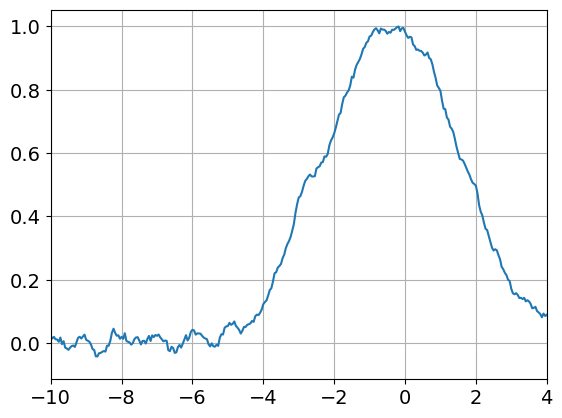

In [93]:
plt.plot(xeV,specs[bb]/np.max(specs[bb]))
plt.grid()
plt.xlim(-10,4)

In [359]:
g= 6

In [355]:
runl[nns[g]]

112

In [356]:
upss[nns[g]]

0.3

In [357]:
pps_trunc[nns[g]]

0.7060454495985944

In [358]:
ids[nns[g]]

114

In [ ]:
# IPAC
# 4th year review
# Hao's paper

In [ ]:
datsall = {'datall': datall, 'mask': mask, 'maskhm': maskhm, 'mdatname': mdatname, 'specdatname': specdatname,\
        'gfsig':gfsig, 'eshift':eshift, 'sc': test['sc'],'thresh': thresh}